<a href="https://colab.research.google.com/github/boubacar-toulba/S5_RGD_Machine-Learning-for-Finance/blob/main/var_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modélisation et Backtesting de la Value-at-Risk : Comparaison de Méthodes Paramétriques, Non-Paramétriques et Machine Learning

## Application à des Portefeuilles Multi-Actifs (Actions, Cryptomonnaies, Mixte)

---

### Projet de Régression en Grande Dimension

**Filière :** Statistique, Économie Appliquée et Big Data  
**Année Universitaire :** 2024-2025

---

### Réalisé par

- **TOULBA Boubacar**
- **CHEMLAL Ismail**
- **IRAQI Hiba**

---

### Encadré par

**Professeur HICHAM Jenati**

---

### Institution

**Institut National de Statistique et d'Économie Appliquée (INSEA)**  
Rabat, Maroc

---

### Date

Décembre 2025

---





# 1 Collecte des Données et Construction des Portefeuilles

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
# --- Répertoires ---
# --- Monter Google Drive ---
drive.mount('/content/drive')  # connecte ton Drive à Colab

# --- Répertoires ---
NOTEBOOK_DIR = Path("/content/drive/MyDrive/Colab Notebooks/var_project")  # dossier du notebook
DATA_DIR = NOTEBOOK_DIR / "data"

# Créer les sous-dossiers si n'existent pas
(DATA_DIR / "raw").mkdir(parents=True, exist_ok=True)
(DATA_DIR / "processed").mkdir(parents=True, exist_ok=True)




# --- Univers ---
stocks = ["AAPL","MSFT","AMZN","GOOGL","NVDA","META","NFLX","AMD","TSLA","QCOM"]
crypto = ["BTC-USD","ETH-USD"]
mix = ["SPY","BTC-USD"]  # 50/50
tickers = sorted(set(stocks + crypto + mix))

START = "2017-01-01"

# --- Téléchargement prix ajustés ---
# auto_adjust=True → les 'Close' sont ajustés splits/dividendes
prices = yf.download(tickers, start=START, auto_adjust=True, progress=False)["Close"]
prices = prices.sort_index().ffill()

# Sauvegarde brute
prices.to_csv(DATA_DIR / "raw" / "prices_close.csv")

# --- Rendements log ---
rets = np.log(prices / prices.shift(1))

# Portefeuille A : Actions (EW)
r_stocks = rets[stocks].dropna(how="any")
port_A = r_stocks.mean(axis=1).to_frame("P_A")

# Portefeuille B : Crypto (EW)
r_crypto = rets[crypto].dropna(how="any")
port_B = r_crypto.mean(axis=1).to_frame("P_B")

# Portefeuille C : Mixte (50% SPY, 50% BTC)
r_mix = rets[["SPY","BTC-USD"]].dropna(how="any")
port_C = (0.5*r_mix["SPY"] + 0.5*r_mix["BTC-USD"]).to_frame("P_C")

# Sauvegardes
r_stocks.to_csv(DATA_DIR / "processed" / "returns_stocks.csv")
r_crypto.to_csv(DATA_DIR / "processed" / "returns_crypto.csv")
r_mix.to_csv(DATA_DIR / "processed" / "returns_mix.csv")
pd.concat([port_A, port_B, port_C], axis=1).to_csv(DATA_DIR / "processed" / "returns_portfolios.csv")

# Petites vérifs de sanity check
def summary(df, name):
    print(f"\n== {name} ==")
    print(f"Dates: {df.index.min().date()} → {df.index.max().date()}  |  N={len(df):,}")
    print(df.describe(percentiles=[0.01,0.05,0.5]).T[["mean","std","1%","5%"]].round(4))

summary(r_stocks, "Rendements Actions (individuels)")
summary(r_crypto, "Rendements Crypto (individuels)")
summary(r_mix, "Rendements Mix (individuels)")
summary(pd.concat([port_A,port_B,port_C], axis=1), "Rendements Portefeuilles (P_A, P_B, P_C)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

== Rendements Actions (individuels) ==
Dates: 2017-01-04 → 2025-12-11  |  N=3,264
          mean     std      1%      5%
Ticker                                
AAPL    0.0007  0.0155 -0.0458 -0.0242
MSFT    0.0007  0.0142 -0.0419 -0.0221
AMZN    0.0006  0.0174 -0.0529 -0.0267
GOOGL   0.0006  0.0155 -0.0471 -0.0246
NVDA    0.0013  0.0262 -0.0736 -0.0398
META    0.0005  0.0209 -0.0560 -0.0279
NFLX    0.0006  0.0223 -0.0601 -0.0312
AMD     0.0009  0.0289 -0.0840 -0.0431
TSLA    0.0011  0.0319 -0.0896 -0.0495
QCOM    0.0004  0.0201 -0.0633 -0.0293

== Rendements Crypto (individuels) ==
Dates: 2017-11-10 → 2025-12-11  |  N=2,954
           mean     std      1%      5%
Ticker                                 
BTC-USD  0.0009  0.0354 -0.1044 -0.0541
ETH-USD  0.0008  0.0456 -0.1356 -0.0705

== Rendements Mix (individuels) ==
Dates: 2017-01-04 → 2025-12-11  |  N=3,264

# Formules Mathématiques - Analyse de Portefeuille

## 1. Rendements Logarithmiques

Le rendement logarithmique (log-return) entre deux périodes consécutives est calculé comme suit :

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

**Où :**
- $r_t$ : rendement logarithmique à la période $t$
- $P_t$ : prix ajusté à la période $t$
- $P_{t-1}$ : prix ajusté à la période précédente
- $\ln$ : logarithme naturel (népérien)

**Avantages des rendements logarithmiques :**
- Additivité temporelle : $r_{[0,T]} = \sum_{t=1}^{T} r_t$
- Symétrie des gains et pertes
- Propriétés statistiques favorables (normalité approximative)

---

## 2. Portefeuille Équipondéré (Equally Weighted)

Pour un portefeuille composé de $N$ actifs avec des poids égaux :

$$r_{portfolio,t} = \frac{1}{N} \sum_{i=1}^{N} r_{i,t}$$

**Où :**
- $r_{portfolio,t}$ : rendement du portefeuille à la période $t$
- $r_{i,t}$ : rendement de l'actif $i$ à la période $t$
- $N$ : nombre d'actifs dans le portefeuille

**Application dans le code :**

### Portefeuille A (Actions) :
$$r_{A,t} = \frac{1}{10} \sum_{i=1}^{10} r_{stock_i,t}$$

### Portefeuille B (Crypto) :
$$r_{B,t} = \frac{1}{2} (r_{BTC,t} + r_{ETH,t})$$

---

## 3. Portefeuille Pondéré (Weighted Portfolio)

Pour un portefeuille avec des poids spécifiques :

$$r_{portfolio,t} = \sum_{i=1}^{N} w_i \cdot r_{i,t}$$

**Avec la contrainte :**
$$\sum_{i=1}^{N} w_i = 1$$

**Où :**
- $w_i$ : poids de l'actif $i$ dans le portefeuille
- $r_{i,t}$ : rendement de l'actif $i$ à la période $t$

**Application dans le code :**

### Portefeuille C (Mix 50/50) :
$$r_{C,t} = 0.5 \cdot r_{SPY,t} + 0.5 \cdot r_{BTC,t}$$

---

## 4. Statistiques Descriptives

### Rendement Moyen (Mean Return)
$$\bar{r} = \frac{1}{T} \sum_{t=1}^{T} r_t$$

### Écart-Type (Volatilité)
$$\sigma = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} (r_t - \bar{r})^2}$$

### Quantiles (Percentiles)
Les quantiles $q_\alpha$ satisfont :
$$P(r_t \leq q_\alpha) = \alpha$$

**Dans le code :**
- 1% : $q_{0.01}$ (queue gauche de distribution)
- 5% : $q_{0.05}$ (Value-at-Risk approximative)
- 50% : $q_{0.50}$ (médiane)

---

## 5. Prix Ajustés (Adjusted Close)

Les prix ajustés tiennent compte des événements corporatifs :

$$P_{adj,t} = P_{raw,t} \times \prod_{s \leq t} CF_s$$

**Où :**
- $P_{adj,t}$ : prix ajusté à la date $t$
- $P_{raw,t}$ : prix brut (non ajusté)
- $CF_s$ : facteur de correction pour dividendes, splits, etc.

**Note :** L'utilisation de `auto_adjust=True` dans yfinance applique automatiquement ces corrections.

---

## 6. Forward Fill (ffill)

Méthode d'imputation pour les valeurs manquantes :

$$P_t = \begin{cases}
P_t & \text{si } P_t \text{ existe} \\
P_{t-k} & \text{où } k = \min\{j : P_{t-j} \text{ existe}\}
\end{cases}$$

Cette méthode propage la dernière valeur observée vers l'avant pour combler les trous dans les données.

---

## 7. Formules Complémentaires pour l'Analyse VaR

### Rendement Annualisé
$$r_{annual} = \bar{r} \times 252$$

### Volatilité Annualisée
$$\sigma_{annual} = \sigma \times \sqrt{252}$$

### Ratio de Sharpe
$$SR = \frac{r_{annual} - r_f}{\sigma_{annual}}$$

**Où :**
- $252$ : nombre de jours de trading par an
- $r_f$ : taux sans risque

---

## 8. Notation Utilisée

| Symbole | Signification |
|---------|---------------|
| $r_t$ | Rendement logarithmique à la période $t$ |
| $P_t$ | Prix de l'actif à la période $t$ |
| $N$ | Nombre d'actifs dans le portefeuille |
| $w_i$ | Poids de l'actif $i$ |
| $T$ | Nombre total de périodes |
| $\bar{r}$ | Rendement moyen |
| $\sigma$ | Écart-type (volatilité) |
| $\ln$ | Logarithme naturel |

---

## Structure des Données dans le Code

```
Univers d'investissement :
├── Portefeuille A : 10 actions (AAPL, MSFT, AMZN, etc.)
├── Portefeuille B : 2 cryptomonnaies (BTC-USD, ETH-USD)
└── Portefeuille C : Mix 50% SPY + 50% BTC-USD

Transformation des données :
Prix → Rendements log → Portefeuilles équipondérés/pondérés
```

---

**Date de début des données :** 2017-01-01  
**Fréquence :** Quotidienne  
**Ajustement :** Prix ajustés pour splits et dividendes


📁 Fichier: returns_stocks.csv
Période: 2017-01-04 → 2025-12-11
Nombre d'observations: 3,264
Colonnes: ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'META', 'NFLX', 'AMD', 'TSLA', 'QCOM']

Aperçu des données:
                AAPL      MSFT      AMZN     GOOGL      NVDA      META  \
Date                                                                     
2017-01-04 -0.001119 -0.004484  0.004646 -0.000297  0.023063  0.015538   
2017-01-05  0.005072  0.000000  0.030270  0.006478 -0.025714  0.016545   
2017-01-06  0.011087  0.008631  0.019716  0.014882  0.013279  0.022453   
2017-01-07  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2017-01-08  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                NFLX       AMD      TSLA      QCOM  
Date                                                
2017-01-04  0.014948  0.000000  0.045055  0.001070  
2017-01-05  0.018376 -0.016763 -0.001058  0.001221  
2017-01-06 -0.005630  0.007092  0.009918 -0.000305  
2017-01-07 

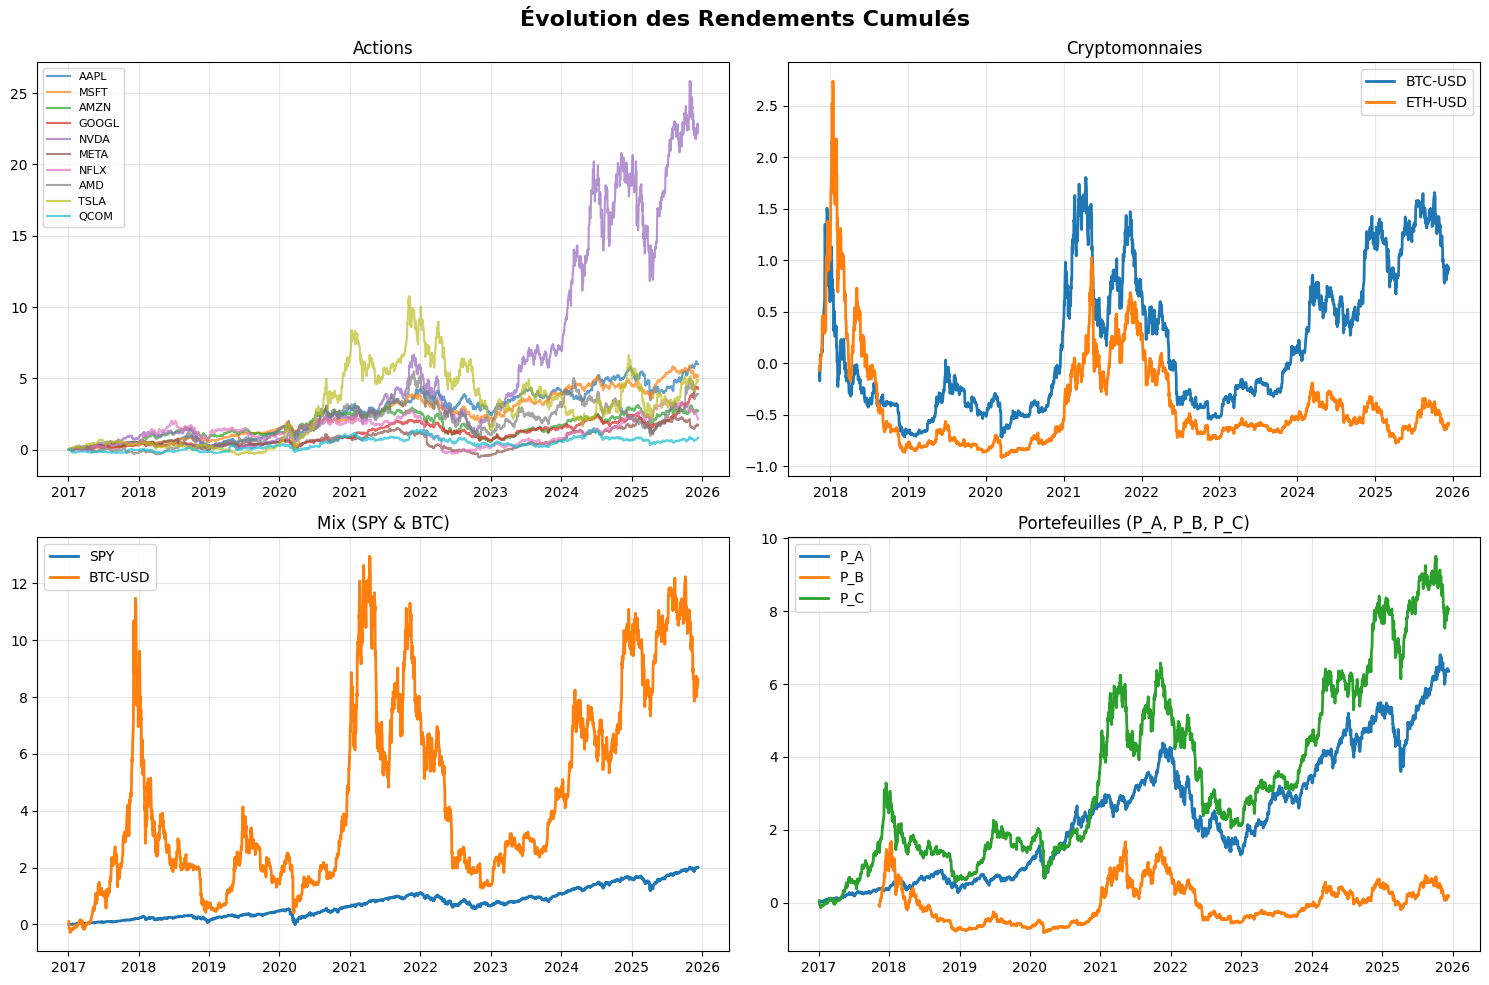

In [ ]:
# Dossier contenant les fichiers CSV
DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/var_project/data/processed")

# Liste des fichiers CSV
csv_files = [
    "returns_stocks.csv",
    "returns_crypto.csv",
    "returns_mix.csv",
    "returns_portfolios.csv"
]

# Lire et afficher les infos de chaque fichier
for file in csv_files:
    df = pd.read_csv(DATA_DIR / file, index_col=0, parse_dates=True)

    print(f"\n{'='*60}")
    print(f"📁 Fichier: {file}")
    print(f"{'='*60}")
    print(f"Période: {df.index.min().date()} → {df.index.max().date()}")
    print(f"Nombre d'observations: {len(df):,}")
    print(f"Colonnes: {list(df.columns)}")
    print(f"\nAperçu des données:")
    print(df.head())
    print(f"\nStatistiques:")
    print(df.describe().round(4))

# Graphiques des rendements cumulés
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Évolution des Rendements Cumulés', fontsize=16, fontweight='bold')

# Stocks
df_stocks = pd.read_csv(DATA_DIR / "returns_stocks.csv", index_col=0, parse_dates=True)
cumret_stocks = (1 + df_stocks).cumprod() - 1
for col in cumret_stocks.columns:
    axes[0, 0].plot(cumret_stocks.index, cumret_stocks[col], label=col, alpha=0.7)
axes[0, 0].set_title('Actions')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# Crypto
df_crypto = pd.read_csv(DATA_DIR / "returns_crypto.csv", index_col=0, parse_dates=True)
cumret_crypto = (1 + df_crypto).cumprod() - 1
for col in cumret_crypto.columns:
    axes[0, 1].plot(cumret_crypto.index, cumret_crypto[col], label=col, linewidth=2)
axes[0, 1].set_title('Cryptomonnaies')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Mix
df_mix = pd.read_csv(DATA_DIR / "returns_mix.csv", index_col=0, parse_dates=True)
cumret_mix = (1 + df_mix).cumprod() - 1
for col in cumret_mix.columns:
    axes[1, 0].plot(cumret_mix.index, cumret_mix[col], label=col, linewidth=2)
axes[1, 0].set_title('Mix (SPY & BTC)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Portefeuilles
df_port = pd.read_csv(DATA_DIR / "returns_portfolios.csv", index_col=0, parse_dates=True)
cumret_port = (1 + df_port).cumprod() - 1
for col in cumret_port.columns:
    axes[1, 1].plot(cumret_port.index, cumret_port[col], label=col, linewidth=2)
axes[1, 1].set_title('Portefeuilles (P_A, P_B, P_C)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2 Baselines : Historical Simulation (HS), Variance-Covariance (VC), EWMA.

# Formules Mathématiques - VaR et Backtesting

## 1. VaR Historique

$$q_\alpha^{HS}(t) = \text{Quantile}_\alpha\{r_{t-W}, \ldots, r_{t-1}\}$$

Quantile empirique sur fenêtre roulante de $W = 500$ observations.

---

## 2. VaR Variance-Covariance

$$q_\alpha^{VC}(t) = \mu_t + z_\alpha \cdot \sigma_t$$

**Où :**
- $\mu_t$ = moyenne mobile sur $W$ observations
- $\sigma_t$ = écart-type mobile sur $W$ observations  
- $z_\alpha = \Phi^{-1}(\alpha)$ = quantile normal standard

---

## 3. VaR avec EWMA

$$\mu_t^{EWMA} = \lambda \mu_{t-1} + (1-\lambda) r_{t-1}$$

$$\sigma_t^{2,EWMA} = \lambda \sigma_{t-1}^2 + (1-\lambda)(r_{t-1} - \mu_{t-1})^2$$

$$q_\alpha^{EWMA}(t) = \mu_t^{EWMA} + z_\alpha \cdot \sigma_t^{EWMA}$$

Avec $\lambda = 0.94$

---

## 4. Test de Kupiec (1995)

$$LR_{UC} = -2 \left[ (T-X)\ln(1-\alpha) + X\ln(\alpha) - (T-X)\ln(1-\hat{p}) - X\ln(\hat{p}) \right]$$

**Où :** $X$ = nombre de dépassements, $\hat{p} = X/T$

**Distribution :** $LR_{UC} \sim \chi^2(1)$

---

## 5. Test de Christoffersen (1998)

$$LR_{IND} = -2\ln\left(\frac{L_{iid}}{L_{ind}}\right)$$

**Où :**

$$L_{ind} = (1-\pi_0)^{n_{00}} \cdot \pi_0^{n_{01}} \cdot (1-\pi_1)^{n_{10}} \cdot \pi_1^{n_{11}}$$

$$L_{iid} = (1-\pi)^{n_{00}+n_{10}} \cdot \pi^{n_{01}+n_{11}}$$

**Distribution :** $LR_{IND} \sim \chi^2(1)$

---

## 6. Test Conjoint

$$LR_{CC} = LR_{UC} + LR_{IND} \sim \chi^2(2)$$

---

## 7. Expected Shortfall (ES)

$$\widehat{ES}_\alpha = -\frac{1}{X}\sum_{t : r_t < q_{\alpha,t}} r_t$$

Perte moyenne lors des dépassements.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/var_project")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

# ------------------------------
# Paramètres
# ------------------------------
DATA_RET = Path("data/processed/returns_portfolios.csv")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

WINDOW = 500                 # taille de fenêtre roulante
ALPHAS = [0.01, 0.05]        # niveaux de VaR
PORTS = ["P_A", "P_B", "P_C"]  # noms des colonnes
EPS = 1e-10                  # stabilité num.

# ------------------------------
# Utils: tests de backtest
# ------------------------------
def kupiec_pof(breaches: pd.Series, alpha: float):
    """Test de couverture inconditionnelle (Kupiec, 1995)."""
    T = len(breaches)
    x = int(breaches.sum())
    p_hat = max(EPS, min(1-EPS, x / T))  # éviter log(0)
    lr_uc = -2.0 * (
        (T - x) * np.log(1 - alpha + EPS) + x * np.log(alpha + EPS)
        - ((T - x) * np.log(1 - p_hat + EPS) + x * np.log(p_hat + EPS))
    )
    pval = 1 - chi2.cdf(lr_uc, df=1)
    return lr_uc, pval, x, T

def christoffersen_independence(breaches: pd.Series):
    """Test d'indépendance des dépassements (Christoffersen, 1998)."""
    b = breaches.astype(int).values
    if len(b) < 2:
        return np.nan, np.nan
    # Compter transitions n_ij
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(b)):
        prev, curr = b[i-1], b[i]
        if prev == 0 and curr == 0:
            n00 += 1
        elif prev == 0 and curr == 1:
            n01 += 1
        elif prev == 1 and curr == 0:
            n10 += 1
        else:
            n11 += 1
    n0 = n00 + n01
    n1 = n10 + n11
    # Probabilités MLE
    pi0 = n01 / n0 if n0 > 0 else 0.0
    pi1 = n11 / n1 if n1 > 0 else 0.0
    pi = (n01 + n11) / (n0 + n1 + EPS)

    # Vraisemblances (corrigé: exposants entre parenthèses)
    L_ind = ((1 - pi0 + EPS)**n00) * ((pi0 + EPS)**n01) * ((1 - pi1 + EPS)**n10) * ((pi1 + EPS)**n11)
    L_iid = ((1 - pi + EPS)**(n00 + n10)) * ((pi + EPS)**(n01 + n11))
    lr_ind = -2.0 * np.log(L_iid / (L_ind + EPS) + EPS)
    pval = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, pval

def backtest_series(real_ret: pd.Series, q_pred: pd.Series, alpha: float):
    """Évalue les prédictions de quantile (retours) : breaches si r_t < q_pred_t."""
    df = pd.concat({"r": real_ret, "q": q_pred}, axis=1).dropna()
    breaches = (df["r"] < df["q"]).astype(int)
    lr_uc, p_uc, x, T = kupiec_pof(breaches, alpha)
    lr_ind, p_ind = christoffersen_independence(breaches)
    lr_cc = lr_uc + lr_ind
    p_cc = 1 - chi2.cdf(lr_cc, df=2)
    es_real = -df.loc[breaches.astype(bool), "r"].mean() if breaches.sum() > 0 else np.nan
    hit_rate = x / T if T > 0 else np.nan
    return {
        "T": T, "breaches": int(x), "hit_rate": hit_rate,
        "Kupiec_LR": lr_uc, "Kupiec_p": p_uc,
        "Christoff_LR": lr_ind, "Christoff_p": p_ind,
        "Joint_LR": lr_cc, "Joint_p": p_cc,
        "ES_realised": es_real
    }

# ------------------------------
# Estimateurs de VaR (quantiles de retours)
# ------------------------------
def rolling_hist_quantile(series: pd.Series, alpha: float, window: int) -> pd.Series:
    """Quantile empirique sur fenêtre roulante -> retourne q_alpha (retour)."""
    q = series.rolling(window, min_periods=window).quantile(alpha)
    # On prédit le quantile pour t+1 : décaler d'un cran
    return q.shift(1).rename(f"q_HS_{int(alpha*100)}")

def rolling_varcov_quantile(series: pd.Series, alpha: float, window: int, ewma: bool=False, lam: float=0.94) -> pd.Series:
    """Quantile gaussien µ + zα σ sur fenêtre roulante (option EWMA)."""
    if ewma:
        # EWMA mean/var
        r = series
        mu = r.ewm(alpha=1-lam, adjust=False).mean()
        var = (r - mu)**2
        sigma = np.sqrt(var.ewm(alpha=1-lam, adjust=False).mean())
        mu_roll = mu
        sigma_roll = sigma
    else:
        mu_roll = series.rolling(window, min_periods=window).mean()
        sigma_roll = series.rolling(window, min_periods=window).std(ddof=1)

    z = norm.ppf(alpha)
    q = mu_roll + z * sigma_roll
    return q.shift(1).rename(f"q_VC_{'EWMA_' if ewma else ''}{int(alpha*100)}")

# ------------------------------
# Main
# ------------------------------
def main():
    # Charger rendements portefeuille
    rets = pd.read_csv(DATA_RET, index_col=0, parse_dates=True)
    rets = rets[PORTS].dropna(how="any")

    summaries = []
    all_preds = []

    for port in PORTS:
        r = rets[port].copy()

        for alpha in ALPHAS:
            # 1) VaR Historique
            q_hs = rolling_hist_quantile(r, alpha, WINDOW)
            # 2) VaR Variance-Covariance (simple) + EWMA (bonus)
            q_vc = rolling_varcov_quantile(r, alpha, WINDOW, ewma=False)
            q_ew = rolling_varcov_quantile(r, alpha, WINDOW, ewma=True, lam=0.94)

            # Sauvegarder prédictions
            preds = pd.concat([q_hs, q_vc, q_ew], axis=1)
            preds.to_csv(RESULTS_DIR / f"var_preds_{port}_a{int(alpha*100)}.csv")
            all_preds.append(preds.add_prefix(f"{port}_a{int(alpha*100)}_"))

            # Backtest
            for name, q in {"HS": q_hs, "VC": q_vc, "VC_EWMA": q_ew}.items():
                res = backtest_series(r, q, alpha)
                res.update({"portfolio": port, "alpha": alpha, "model": name})
                summaries.append(res)

            # Plot (facultatif, 1 figure par combinaison)
            fig, ax = plt.subplots(figsize=(10, 4))
            r.plot(ax=ax, label="retour")
            q_hs.plot(ax=ax, label=f"q_HS@{int(alpha*100)}")
            q_vc.plot(ax=ax, label=f"q_VC@{int(alpha*100)}")
            q_ew.plot(ax=ax, label=f"q_VC_EWMA@{int(alpha*100)}")
            ax.set_title(f"{port} — quantiles de retours (α={alpha})")
            ax.legend()
            ax.axhline(0, lw=0.8, color="k")
            fig.tight_layout()
            fig.savefig(RESULTS_DIR / f"plot_{port}_a{int(alpha*100)}.png", dpi=160)
            plt.close(fig)

    # Tableau récapitulatif
    df_sum = pd.DataFrame(summaries)
    # Ordonner joliment
    df_sum = df_sum.sort_values(["portfolio", "alpha", "model"]).reset_index(drop=True)
    # Ajouter VaR en perte moyenne lors des dépassements (déjà dans ES_realised)
    df_sum.to_csv(RESULTS_DIR / "backtest_summary.csv", index=False)

    # Aperçu console
    print("\n=== Résumé Backtests ===")
    cols_show = ["portfolio", "alpha", "model", "T", "breaches", "hit_rate",
                 "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]
    print(df_sum[cols_show].to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

    # Sauvegarde d'un fichier combiné de toutes les prédictions (optionnel)
    pd.concat(all_preds, axis=1).to_csv(RESULTS_DIR / "all_var_predictions_wide.csv")

if __name__ == "__main__":
    main()


=== Résumé Backtests ===
portfolio  alpha   model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100      HS 2454        32    0.0130    0.1482       0.0000   0.0000       0.0612
      P_A 0.0100      VC 2454        66    0.0269    0.0000       0.0000   0.0000       0.0494
      P_A 0.0100 VC_EWMA 2953       101    0.0342    0.0000       0.0000   0.0000       0.0375
      P_A 0.0500      HS 2454       127    0.0518    0.6920       0.0000   0.0000       0.0409
      P_A 0.0500      VC 2454       140    0.0570    0.1167       0.0000   0.0000       0.0396
      P_A 0.0500 VC_EWMA 2953       223    0.0755    0.0000       0.0000   0.0000       0.0319
      P_B 0.0100      HS 2454        32    0.0130    0.1482       0.0000   0.0000       0.1289
      P_B 0.0100      VC 2454        45    0.0183    0.0002       0.0000   0.0000       0.1179
      P_B 0.0100 VC_EWMA 2953        84    0.0284    0.0000       0.0000   0.0000       0.1023
      P_B 0.0500      HS

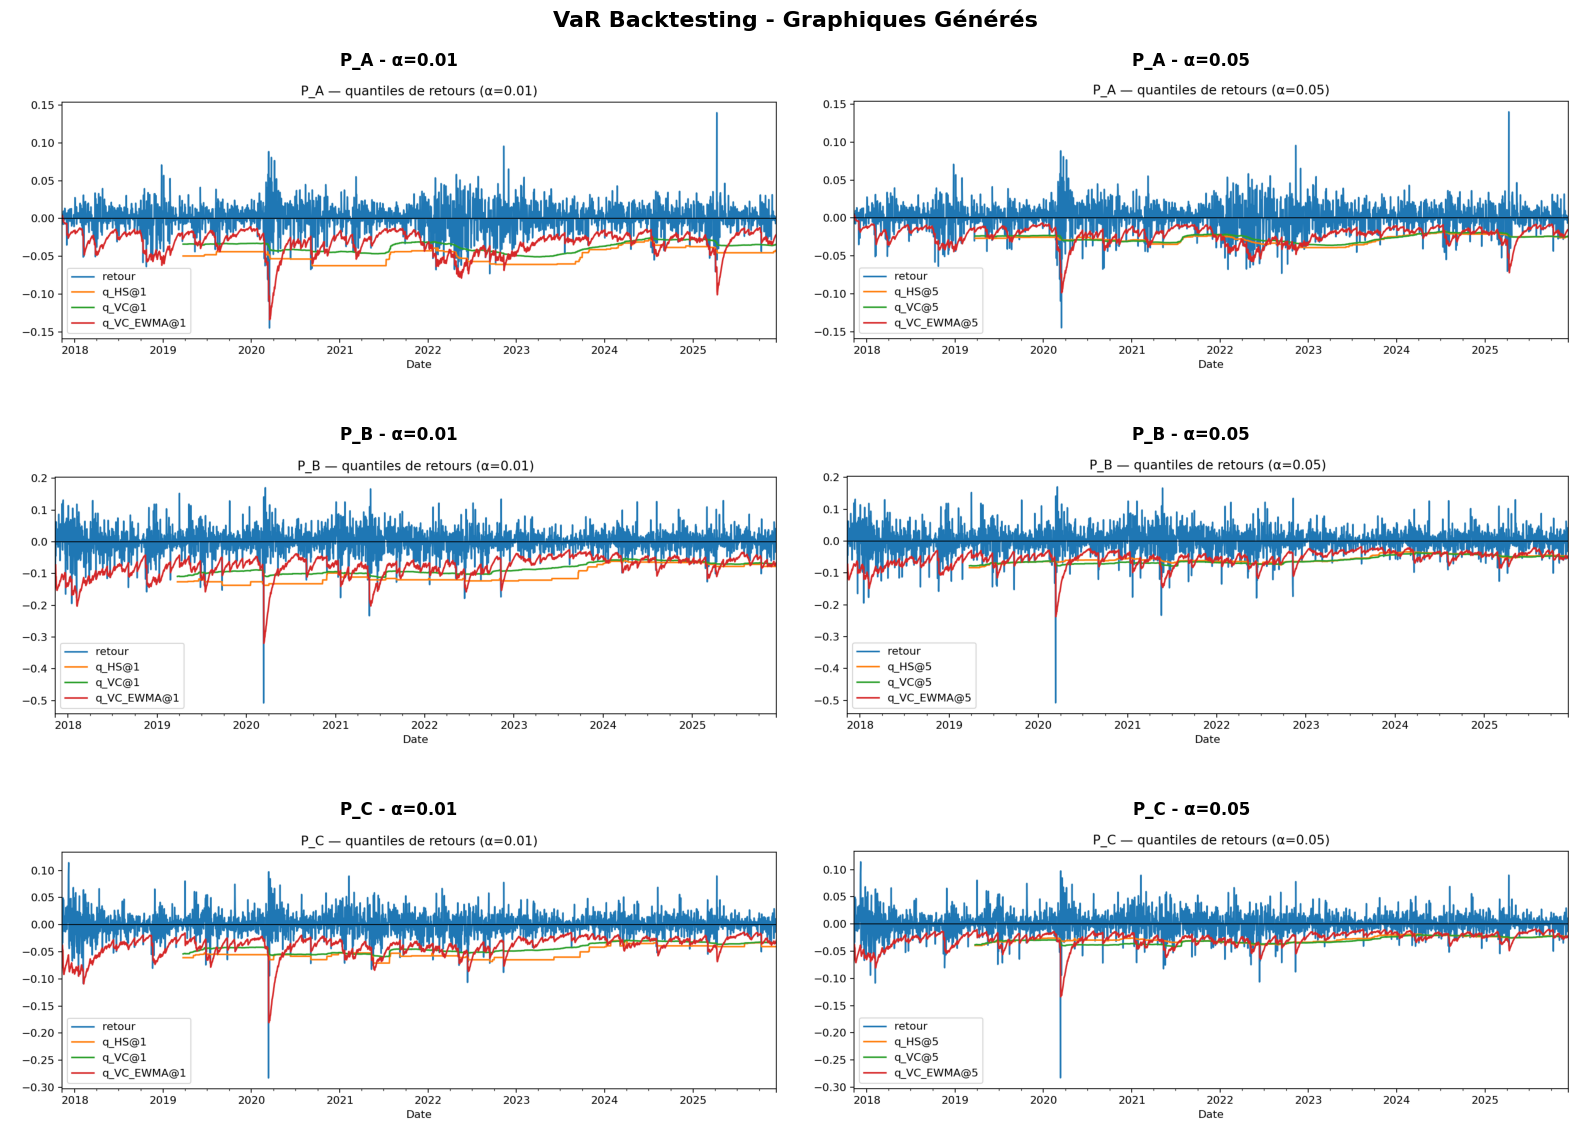

In [6]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Paramètres
RESULTS_DIR = Path("results")
PORTS = ["P_A", "P_B", "P_C"]
ALPHAS = [0.01, 0.05]

# Créer une matrice de graphiques
fig, axes = plt.subplots(len(PORTS), len(ALPHAS), figsize=(16, 12))
fig.suptitle('VaR Backtesting - Graphiques Générés', fontsize=16, fontweight='bold')

for i, port in enumerate(PORTS):
    for j, alpha in enumerate(ALPHAS):
        ax = axes[i, j]

        # Charger l'image générée
        img_file = RESULTS_DIR / f"plot_{port}_a{int(alpha*100)}.png"
        img = imread(img_file)

        # Afficher l'image
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{port} - α={alpha}', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()


# 3 Modèles économétriques : GARCH(1,1)-t.

# Formules Mathématiques - GARCH VaR

## 1. Modèle GARCH(1,1)

### Équation des rendements
$$r_t = \mu + \epsilon_t, \quad \epsilon_t = \sigma_t z_t$$

**Où :**
- $r_t$ : rendement à la date $t$
- $\mu$ : rendement moyen (constante)
- $\epsilon_t$ : terme d'erreur (innovation)
- $\sigma_t$ : volatilité conditionnelle
- $z_t$ : innovation standardisée, $z_t \sim \text{Distribution}(0,1)$

---

### Équation de la variance conditionnelle
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

**Paramètres :**
- $\omega > 0$ : terme constant (variance de long terme)
- $\alpha \geq 0$ : coefficient ARCH (réaction aux chocs passés)
- $\beta \geq 0$ : coefficient GARCH (persistance de la volatilité)

**Contrainte de stationnarité :** $\alpha + \beta < 1$

---

## 2. Distributions des Innovations

### Distribution Normale
$$z_t \sim \mathcal{N}(0, 1)$$

### Distribution Student-t
$$z_t \sim t(\nu)$$

**Où :** $\nu$ = degrés de liberté

**Avantage :** Capture les queues épaisses (fat tails) des rendements financiers.

---

## 3. VaR GARCH

### Prévision 1-step ahead
$$\text{VaR}_{\alpha,t+1} = \mu + z_\alpha \cdot \sigma_{t+1}$$

**Où :**
- $z_\alpha$ : quantile de la distribution standardisée
  - Normal : $z_\alpha = \Phi^{-1}(\alpha)$
  - Student-t : $z_\alpha = t_\nu^{-1}(\alpha)$
- $\sigma_{t+1}$ : volatilité prédite via l'équation GARCH

---

## 4. Mise à Jour Récursive (entre refits)

### Étape 1 : Calcul de l'innovation passée
$$\epsilon_{t-1} = r_{t-1} - \mu$$

### Étape 2 : Mise à jour de la variance
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

### Étape 3 : Calcul du quantile
$$q_{\alpha,t} = \frac{\mu + z_\alpha \cdot \sigma_t}{100}$$

**Note :** Division par 100 car le modèle `arch` travaille en pourcentages.

---

## 5. Stratégie de Refit

### Refit périodique
- **Refit complet** : tous les `refit_every = 20` jours
- **Mise à jour récursive** : entre les refits

**Avantages :**
- Réduit le temps de calcul
- Maintient l'adaptation aux changements de marché

---

## 6. Fenêtre d'Estimation

$$W = 750 \text{ jours} \approx 3 \text{ ans de trading}$$

Les paramètres $(\omega, \alpha, \beta, \nu)$ sont estimés sur les $W$ dernières observations.

---

## 7. Tests de Backtesting

### Test de Kupiec (Proportion)
$$LR_{UC} = -2 \left[ (T-X)\ln(1-\alpha) + X\ln(\alpha) - (T-X)\ln(1-\hat{p}) - X\ln(\hat{p}) \right]$$

**Distribution :** $LR_{UC} \sim \chi^2(1)$

---

### Test de Christoffersen (Indépendance)
$$LR_{IND} = -2\ln\left(\frac{L_{iid}}{L_{ind}}\right)$$

**Où :**
$$L_{ind} = (1-\pi_0)^{n_{00}} \cdot \pi_0^{n_{01}} \cdot (1-\pi_1)^{n_{10}} \cdot \pi_1^{n_{11}}$$

$$L_{iid} = (1-\pi)^{n_{00}+n_{10}} \cdot \pi^{n_{01}+n_{11}}$$

**Distribution :** $LR_{IND} \sim \chi^2(1)$

---

### Test Conjoint
$$LR_{CC} = LR_{UC} + LR_{IND} \sim \chi^2(2)$$

---

## 8. Expected Shortfall (ES)

$$\widehat{ES}_\alpha = -\frac{1}{X}\sum_{t : r_t < q_{\alpha,t}} r_t$$

Perte moyenne conditionnelle aux dépassements.

---

## 9. Paramètres du Code

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| $W$ | 750 | Fenêtre d'estimation (≈3 ans) |
| `refit_every` | 20 | Refit GARCH tous les 20 jours |
| $\alpha$ | 0.01, 0.05 | Niveaux de VaR (1%, 5%) |
| `dist` | "t" | Distribution des innovations (Student-t) |
| $\epsilon$ | $10^{-12}$ | Constante de stabilité numérique |

---

## 10. Workflow du Code

```
1. Charger les rendements r_t
2. Pour chaque portefeuille :
   a) Convertir en pourcentages : y_t = r_t × 100
   b) Pour t = W, W+1, ..., T :
      - Si (t - last_refit) ≥ 20 :
          * Estimer GARCH(1,1) sur [t-W, t-1]
          * Extraire (μ, ω, α, β, ν)
      - Sinon :
          * Mise à jour récursive : σ²_t = ω + α·ε²_{t-1} + β·σ²_{t-1}
      - Calculer VaR : q_α,t = (μ + z_α·σ_t)/100
   c) Backtest (Kupiec, Christoffersen, ES)
   d) Sauvegarder résultats et graphiques
```

---

## Références

- Bollerslev, T. (1986). "Generalized Autoregressive Conditional Heteroskedasticity"
- Kupiec, P. (1995). "Techniques for Verifying the Accuracy of Risk Measurement Models"
- Christoffersen, P. (1998). "Evaluating Interval Forecasts"

In [8]:
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 46.1 MB/s eta 0:00:00


In [9]:
# 03_garch_var_backtest.py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, t as student_t
from arch import arch_model

# ------------------------------
# Paramètres globaux
# ------------------------------
DATA_RET = Path("data/processed/returns_portfolios.csv")
RESULTS = Path("results")
RESULTS.mkdir(parents=True, exist_ok=True)

PORTS  = ["P_A", "P_B", "P_C"]     # colonnes attendues
ALPHAS = [0.01, 0.05]              # niveaux VaR
WINDOW = 750                       # fenêtre d'estimation (jours)
REFIT_EVERY = 20                   # refit complet tous les N jours (compromis vitesse/qualité)
DIST = "t"                         # innovations: "t" recommandé
EPS = 1e-12

# ------------------------------
# Tests de backtest (Kupiec/Christoffersen)
# ------------------------------
def kupiec_pof(breaches: pd.Series, alpha: float):
    T = len(breaches)
    x = int(breaches.sum())
    p_hat = min(max(x / max(T, 1), EPS), 1-EPS)
    lr_uc = -2.0 * (
        (T - x) * np.log(1 - alpha + EPS) + x * np.log(alpha + EPS)
        - ((T - x) * np.log(1 - p_hat + EPS) + x * np.log(p_hat + EPS))
    )
    return lr_uc, 1 - chi2.cdf(lr_uc, 1), x, T

def christoffersen_independence(breaches: pd.Series):
    b = breaches.astype(int).values
    if len(b) < 2:
        return np.nan, np.nan
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(b)):
        p, c = b[i-1], b[i]
        if   p == 0 and c == 0:
            n00 += 1
        elif p == 0 and c == 1:
            n01 += 1
        elif p == 1 and c == 0:
            n10 += 1
        else:
            n11 += 1
    n0, n1 = n00 + n01, n10 + n11
    pi0 = n01 / n0 if n0 > 0 else 0.0
    pi1 = n11 / n1 if n1 > 0 else 0.0
    pi  = (n01 + n11) / max(n0 + n1, 1)
    # Correction: ajout des exposants manquants
    L_ind = ((1 - pi0 + EPS)**n00) * ((pi0 + EPS)**n01) * ((1 - pi1 + EPS)**n10) * ((pi1 + EPS)**n11)
    L_iid = ((1 - pi + EPS)**(n00 + n10)) * ((pi + EPS)**(n01 + n11))
    lr_ind = -2.0 * np.log(max(L_iid, EPS) / max(L_ind, EPS))
    return lr_ind, 1 - chi2.cdf(lr_ind, 1)

def backtest_series(real_ret: pd.Series, q_pred: pd.Series, alpha: float):
    df = pd.concat({"r": real_ret, "q": q_pred}, axis=1).dropna()
    breaches = (df["r"] < df["q"]).astype(int)
    lr_uc, p_uc, x, T = kupiec_pof(breaches, alpha)
    lr_ind, p_ind = christoffersen_independence(breaches)
    lr_cc = lr_uc + lr_ind
    p_cc = 1 - chi2.cdf(lr_cc, 2)
    es_real = -df.loc[breaches.astype(bool), "r"].mean() if x > 0 else np.nan
    return {
        "T": T, "breaches": int(x), "hit_rate": x / max(T, 1),
        "Kupiec_LR": lr_uc, "Kupiec_p": p_uc,
        "Christoff_LR": lr_ind, "Christoff_p": p_ind,
        "Joint_LR": lr_cc, "Joint_p": p_cc,
        "ES_realised": es_real
    }

# ------------------------------
# GARCH(1,1) rolling avec refit périodique
# ------------------------------
def garch_var_forecasts(r: pd.Series, alphas, window=750, refit_every=20, dist="t"):
    """
    r : rendements quotidien en décimal (ex: 0.01), index datetime.
    Retourne un DataFrame des quantiles prédits (VaR sur retours) alignés en t (prévision pour t).
    Implémentation rapide : refit GARCH sur fenêtre glissante tous les 'refit_every' jours,
    mise à jour entre refits via la récurrence sigma^2_t = w + a*eps^2_{t-1} + b*sigma^2_{t-1}.
    """
    # arch préfère les pourcentages
    y = (r * 100.0).dropna()
    idx = y.index

    cols = [f"q_GARCH_{dist}_{int(a*100)}" for a in alphas]
    q = pd.DataFrame(index=idx, columns=cols, dtype=float)

    # états du modèle (init vide)
    mu = omega = alpha_param = beta = None
    nu = None
    sigma2_prev = None
    last_refit = None

    for i in range(window, len(y)):
        # Refit si nécessaire (au démarrage ou tous les refit_every jours)
        if (last_refit is None) or ((i - last_refit) >= refit_every):
            train = y.iloc[i-window:i]
            # GARCH(1,1) avec moyenne constante
            am = arch_model(train, vol="GARCH", p=1, o=0, q=1, mean="constant", dist=dist)
            res = am.fit(disp="off")
            par = res.params
            mu = float(par.get("mu", 0.0))
            omega = float(par.get("omega", 0.0))
            alpha_param = float(par[[k for k in par.index if k.startswith("alpha")][0]])
            beta  = float(par[[k for k in par.index if k.startswith("beta")][0]])
            nu    = float(par.get("nu", np.nan)) if dist == "t" else None
            # variance conditionnelle au dernier point observé (i-1)
            sigma2_prev = float(res.conditional_volatility.iloc[-1])**2
            last_refit = i

        # Mise à jour récursive pour la variance de t (prévision 1-step ahead)
        eps_prev = y.iloc[i-1] - mu
        sigma2_t = omega + alpha_param * (eps_prev**2) + beta * sigma2_prev
        sigma2_prev = sigma2_t  # pour l'itération suivante

        # Quantiles (innovations t-Student standard ou Normale)
        for a in alphas:
            if dist == "t" and nu and np.isfinite(nu):
                z = student_t.ppf(a, df=nu)
            else:
                z = norm.ppf(a)
            q.iloc[i, q.columns.get_loc(f"q_GARCH_{dist}_{int(a*100)}")] = (mu + z * np.sqrt(sigma2_t)) / 100.0

    # On ne garde que la partie utile (après window)
    return q.dropna(how="all")

# ------------------------------
# Main
# ------------------------------
def main():
    rets = pd.read_csv(DATA_RET, index_col=0, parse_dates=True)[PORTS].dropna(how="any")
    summaries = []
    for port in PORTS:
        r = rets[port].copy()
        preds = garch_var_forecasts(r, ALPHAS, window=WINDOW, refit_every=REFIT_EVERY, dist=DIST)
        preds.to_csv(RESULTS / f"var_preds_{port}_GARCH_{DIST}.csv")

        # Backtests
        for a in ALPHAS:
            name = f"q_GARCH_{DIST}_{int(a*100)}"
            res = backtest_series(r, preds[name], a)
            res.update({"portfolio": port, "alpha": a, "model": f"GARCH(1,1)-{DIST}"})
            summaries.append(res)

            # Plot rapide
            fig, ax = plt.subplots(figsize=(10, 4))
            r.plot(ax=ax, label="retour")
            preds[name].plot(ax=ax, label=f"{name}")
            ax.axhline(0, lw=0.8, color="k")
            ax.set_title(f"{port} — VaR GARCH (α={a})")
            ax.legend()
            fig.tight_layout()
            fig.savefig(RESULTS / f"plot_{port}_GARCH_{DIST}_a{int(a*100)}.png", dpi=160)
            plt.close(fig)

    df_sum = pd.DataFrame(summaries).sort_values(["portfolio", "alpha"]).reset_index(drop=True)
    df_sum.to_csv(RESULTS / "backtest_summary_GARCH.csv", index=False)

    print("\n=== Résumé Backtests GARCH ===")
    cols = ["portfolio", "alpha", "model", "T", "breaches", "hit_rate", "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]
    print(df_sum[cols].to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

if __name__ == "__main__":
    main()


=== Résumé Backtests GARCH ===
portfolio  alpha        model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100 GARCH(1,1)-t 2204         0    0.0000    0.0000       1.0000   0.0000          NaN
      P_A 0.0500 GARCH(1,1)-t 2204        20    0.0091    0.0000       1.0000   0.0000       0.0527
      P_B 0.0100 GARCH(1,1)-t 2204         7    0.0032    0.0002       1.0000   0.0009       0.2117
      P_B 0.0500 GARCH(1,1)-t 2204        40    0.0181    0.0000       1.0000   0.0000       0.1147
      P_C 0.0100 GARCH(1,1)-t 2204         4    0.0018    0.0000       1.0000   0.0000       0.1294
      P_C 0.0500 GARCH(1,1)-t 2204        36    0.0163    0.0000       1.0000   0.0000       0.0614


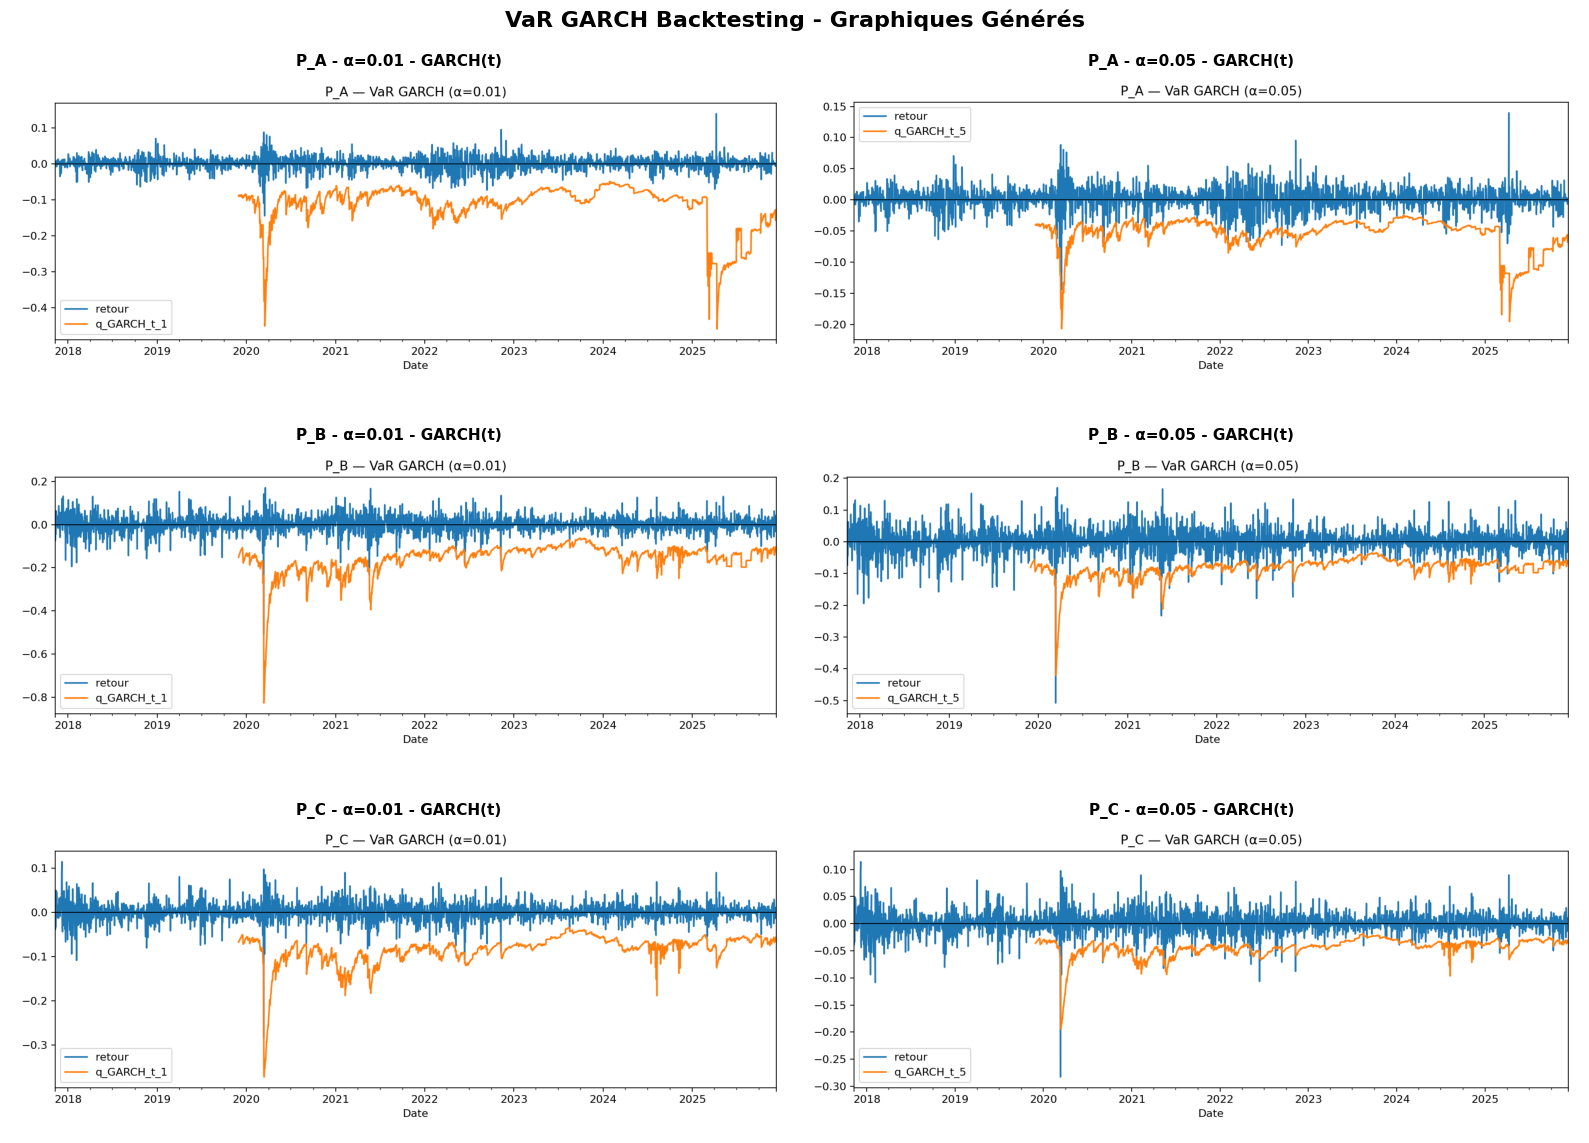


RÉSULTATS DU BACKTESTING GARCH
portfolio  alpha        model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100 GARCH(1,1)-t 2204         0    0.0000    0.0000       1.0000   0.0000          NaN
      P_A 0.0500 GARCH(1,1)-t 2204        20    0.0091    0.0000       1.0000   0.0000       0.0527
      P_B 0.0100 GARCH(1,1)-t 2204         7    0.0032    0.0002       1.0000   0.0009       0.2117
      P_B 0.0500 GARCH(1,1)-t 2204        40    0.0181    0.0000       1.0000   0.0000       0.1147
      P_C 0.0100 GARCH(1,1)-t 2204         4    0.0018    0.0000       1.0000   0.0000       0.1294
      P_C 0.0500 GARCH(1,1)-t 2204        36    0.0163    0.0000       1.0000   0.0000       0.0614


In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Paramètres
RESULTS_DIR = Path("results")
PORTS = ["P_A", "P_B", "P_C"]
ALPHAS = [0.01, 0.05]
DIST = "t"

# Créer une matrice de graphiques GARCH
fig, axes = plt.subplots(len(PORTS), len(ALPHAS), figsize=(16, 12))
fig.suptitle('VaR GARCH Backtesting - Graphiques Générés', fontsize=16, fontweight='bold')

for i, port in enumerate(PORTS):
    for j, alpha in enumerate(ALPHAS):
        ax = axes[i, j]

        # Charger l'image générée par le code GARCH
        img_file = RESULTS_DIR / f"plot_{port}_GARCH_{DIST}_a{int(alpha*100)}.png"

        if img_file.exists():
            img = imread(img_file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'{port} - α={alpha} - GARCH({DIST})', fontweight='bold', fontsize=11)
        else:
            ax.text(0.5, 0.5, f'Fichier non trouvé:\n{img_file.name}',
                    ha='center', va='center', fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

# Afficher aussi le tableau des résultats GARCH
print("\n" + "="*80)
print("RÉSULTATS DU BACKTESTING GARCH")
print("="*80)

summary_file = RESULTS_DIR / "backtest_summary_GARCH.csv"
if summary_file.exists():
    import pandas as pd
    summary = pd.read_csv(summary_file)
    cols = ["portfolio", "alpha", "model", "T", "breaches", "hit_rate",
            "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]
    print(summary[cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
else:
    print("Fichier backtest_summary_GARCH.csv non trouvé!")

# 4 Méthodes de simulation : Monte Carlo (MVN, MVT, Copule t).

# Formules Mathématiques - Monte-Carlo et Copules

## 1. Simulation Monte-Carlo - Vue d'Ensemble

### Principe général
$$\text{VaR}_\alpha = \text{Quantile}_\alpha\{r_{portfolio}^{(1)}, r_{portfolio}^{(2)}, \ldots, r_{portfolio}^{(N_{sim})}\}$$

Générer $N_{sim} = 10\,000$ scénarios de rendements multivariés et calculer le quantile du portefeuille.

---

## 2. VaR Monte-Carlo - Distribution Normale Multivariée (MVN)

### Modèle
$$\mathbf{r} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\Sigma})$$

**Où :**
- $\boldsymbol{\mu}$ : vecteur des moyennes (estimé sur fenêtre $W$)
- $\boldsymbol{\Sigma}$ : matrice de covariance (estimée sur fenêtre $W$)

### Simulation
$$\mathbf{r}^{(s)} = \boldsymbol{\mu} + \mathbf{L} \mathbf{z}^{(s)}, \quad \mathbf{z}^{(s)} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

**Où :** $\mathbf{L}$ est la décomposition de Cholesky de $\boldsymbol{\Sigma}$ : $\boldsymbol{\Sigma} = \mathbf{L}\mathbf{L}^T$

### Rendement du portefeuille
$$r_{portfolio}^{(s)} = \mathbf{w}^T \mathbf{r}^{(s)}$$

**Où :** $\mathbf{w}$ = vecteur des poids (somme = 1)

### VaR
$$\text{VaR}_\alpha^{MVN} = \text{Quantile}_\alpha\{r_{portfolio}^{(1)}, \ldots, r_{portfolio}^{(N_{sim})}\}$$

---

## 3. VaR Monte-Carlo - Distribution Student-t Multivariée (MVT)

### Modèle
$$\mathbf{r} \sim t_\nu(\boldsymbol{\mu}, \boldsymbol{\Sigma})$$

**Avantage :** Capture les queues épaisses (fat tails) et les événements extrêmes.

### Paramètre de dispersion
$$\boldsymbol{\Sigma}_{scale} = \boldsymbol{\Sigma} \cdot \frac{\nu - 2}{\nu}$$

**Où :** $\nu$ = degrés de liberté (dans le code : $\nu = 6$)

### Simulation
$$\mathbf{r}^{(s)} = \boldsymbol{\mu} + \frac{\mathbf{L} \mathbf{z}^{(s)}}{\sqrt{U^{(s)}}}$$

**Où :**
- $\mathbf{z}^{(s)} \sim \mathcal{N}(\mathbf{0}, \boldsymbol{\Sigma}_{scale})$
- $U^{(s)} \sim \chi^2_\nu / \nu$ (variable chi-carré normalisée)
- $\mathbf{L}$ : décomposition de Cholesky de $\boldsymbol{\Sigma}_{scale}$

### VaR
$$\text{VaR}_\alpha^{MVT} = \text{Quantile}_\alpha\{r_{portfolio}^{(1)}, \ldots, r_{portfolio}^{(N_{sim})}\}$$

---

## 4. VaR Monte-Carlo - Copule t

### Principe
Sépare la structure de dépendance (copule) des distributions marginales (empiriques).

### Étape 1 : Pseudo-observations (Rangs)
Pour chaque actif $j$ :
$$U_{i,j} = \frac{\text{rang}(r_{i,j})}{n+1}$$

**Où :** $n$ = taille de la fenêtre, $U_{i,j} \in (0,1)$

---

### Étape 2 : Transformation vers l'espace normal
$$Z_{i,j} = t_\nu^{-1}(U_{i,j})$$

**Où :** $t_\nu^{-1}$ = fonction quantile de la loi Student-t avec $\nu$ degrés de liberté

---

### Étape 3 : Matrice de corrélation
$$\mathbf{R} = \text{Corr}(\mathbf{Z})$$

Régularisation pour assurer la positivité définie :
$$\mathbf{R}_{reg} = \mathbf{R} + \epsilon \mathbf{I}$$

---

### Étape 4 : Simulation de la copule t
Générer $\mathbf{Z}^{(s)} \sim t_\nu(\mathbf{0}, \mathbf{R})$ :

$$\mathbf{Z}^{(s)} = \frac{\mathbf{L}_R \mathbf{z}^{(s)}}{\sqrt{U^{(s)}}}$$

**Où :**
- $\mathbf{L}_R$ : Cholesky de $\mathbf{R}_{scale} = \mathbf{R} \cdot \frac{\nu-2}{\nu}$
- $\mathbf{z}^{(s)} \sim \mathcal{N}(\mathbf{0}, \mathbf{R}_{scale})$
- $U^{(s)} \sim \chi^2_\nu / \nu$

---

### Étape 5 : Retour vers l'espace uniforme
$$U_j^{*(s)} = T_\nu(Z_j^{(s)})$$

**Où :** $T_\nu$ = fonction de répartition de la loi Student-t

---

### Étape 6 : Inversion marginale empirique
Pour chaque actif $j$ :
$$r_j^{(s)} = F_j^{-1}(U_j^{*(s)})$$

**Où :** $F_j^{-1}$ = quantile empirique de la marginale $j$ sur la fenêtre

---

### Rendement du portefeuille
$$r_{portfolio}^{(s)} = \mathbf{w}^T \mathbf{r}^{(s)}$$

### VaR
$$\text{VaR}_\alpha^{Copule-t} = \text{Quantile}_\alpha\{r_{portfolio}^{(1)}, \ldots, r_{portfolio}^{(N_{sim})}\}$$

---

## 5. Régularisation de la Matrice de Covariance

Pour éviter les problèmes numériques (matrice non définie positive) :

$$\boldsymbol{\Sigma}_{reg} = \boldsymbol{\Sigma} + \lambda \mathbf{I}$$

**Dans le code :** $\lambda = 10^{-6}$

---

## 6. Tests de Backtesting

### Test de Kupiec
$$LR_{UC} = -2 \left[ (T-X)\ln(1-\alpha) + X\ln(\alpha) - (T-X)\ln(1-\hat{p}) - X\ln(\hat{p}) \right]$$

**Distribution :** $LR_{UC} \sim \chi^2(1)$

---

### Test de Christoffersen
$$LR_{IND} = -2\ln\left(\frac{L_{iid}}{L_{ind}}\right)$$

**Où :**
$$L_{ind} = (1-\pi_0)^{n_{00}} \cdot \pi_0^{n_{01}} \cdot (1-\pi_1)^{n_{10}} \cdot \pi_1^{n_{11}}$$

$$L_{iid} = (1-\pi)^{n_{00}+n_{10}} \cdot \pi^{n_{01}+n_{11}}$$

**Distribution :** $LR_{IND} \sim \chi^2(1)$

---

### Test Conjoint
$$LR_{CC} = LR_{UC} + LR_{IND} \sim \chi^2(2)$$

---

## 7. Expected Shortfall (ES)

$$\widehat{ES}_\alpha = -\frac{1}{X}\sum_{t : r_t < q_{\alpha,t}} r_t$$

---

## 8. Paramètres du Code

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| $W$ | 500 | Fenêtre d'estimation |
| $N_{sim}$ | 10,000 | Nombre de simulations MC |
| $\nu_{MVT}$ | 6 | Degrés de liberté MVT |
| $\nu_{Copule}$ | 6 | Degrés de liberté Copule t |
| $\alpha$ | 0.01, 0.05 | Niveaux de VaR (1%, 5%) |
| $\lambda$ | $10^{-6}$ | Régularisation covariance |

---

## 9. Poids des Portefeuilles

### Portefeuille A (Actions)
$$w_j = \frac{1}{10}, \quad j = 1, \ldots, 10$$

### Portefeuille B (Crypto)
$$w_j = \frac{1}{2}, \quad j = 1, 2 \quad (\text{BTC, ETH})$$

### Portefeuille C (Mix)
$$w_{SPY} = 0.5, \quad w_{BTC} = 0.5$$

---

## 10. Workflow du Code

```
1. Charger les rendements individuels (actions, crypto, mix)
2. Pour chaque portefeuille :
   a) Définir les poids w
   b) Fenêtre roulante de taille W = 500 :
      i)   Calculer μ et Σ sur la fenêtre
      ii)  Générer N_sim scénarios :
           - MVN : r ~ N(μ, Σ)
           - MVT : r ~ t_ν(μ, Σ)
           - Copule-t :
             * Rangs → U
             * U → Z via t^(-1)
             * Corr(Z) → R
             * Simuler Z* ~ MVT(0,R,ν)
             * Z* → U* via t_cdf
             * U* → r via quantile empirique
      iii) Calculer r_portfolio = w^T r
      iv)  VaR_α = Quantile_α(r_portfolio)
   c) Backtest (Kupiec, Christoffersen, ES)
   d) Sauvegarder résultats et graphiques
```

---

## 11. Avantages de Chaque Méthode

| Méthode | Avantages | Limites |
|---------|-----------|---------|
| **MVN** | Simple, rapide | Sous-estime les queues |
| **MVT** | Capture les queues épaisses | Suppose même structure pour tous |
| **Copule-t** | Marginales flexibles + dépendance réaliste | Plus coûteux en calcul |

---

## Références

- Embrechts, P., McNeil, A., & Straumann, D. (2002). "Correlation and Dependence in Risk Management"
- Cherubini, U., Luciano, E., & Vecchiato, W. (2004). "Copula Methods in Finance"
- McNeil, A., Frey, R., & Embrechts, P. (2015). "Quantitative Risk Management"

In [11]:
# 04_mc_copula_var_backtest.py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, t as student_t

# ------------------------------
# Paramètres généraux
# ------------------------------
DATA = Path("data/processed")
RESULTS = Path("results")
RESULTS.mkdir(parents=True, exist_ok=True)

WINDOW = 500             # taille de fenêtre d'estimation
ALPHAS = [0.01, 0.05]    # niveaux VaR
NSIM = 10000             # scénarios MC (augmenter si rapide)
SEED = 42
NU_MVT = 6               # ddl pour MVT portefeuille
NU_COP = 6               # ddl pour copule t
EPS = 1e-10

rng = np.random.default_rng(SEED)

# ------------------------------
# Tests de backtest (Kupiec / Christoffersen)
# ------------------------------
def kupiec_pof(breaches: pd.Series, alpha: float):
    T = len(breaches)
    x = int(breaches.sum())
    p_hat = min(max(x / max(T, 1), EPS), 1-EPS)
    lr_uc = -2.0 * (
        (T - x) * np.log(1 - alpha + EPS) + x * np.log(alpha + EPS)
        - ((T - x) * np.log(1 - p_hat + EPS) + x * np.log(p_hat + EPS))
    )
    pval = 1 - chi2.cdf(lr_uc, df=1)
    return lr_uc, pval, x, T

def christoffersen_independence(breaches: pd.Series):
    b = breaches.astype(int).values
    if len(b) < 2:
        return np.nan, np.nan
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(b)):
        p, c = b[i-1], b[i]
        if   p == 0 and c == 0:
            n00 += 1
        elif p == 0 and c == 1:
            n01 += 1
        elif p == 1 and c == 0:
            n10 += 1
        else:
            n11 += 1
    n0, n1 = n00 + n01, n10 + n11
    pi0 = n01 / n0 if n0 > 0 else 0.0
    pi1 = n11 / n1 if n1 > 0 else 0.0
    pi  = (n01 + n11) / max(n0 + n1, 1)
    # Correction: ajout des exposants manquants
    L_ind = ((1 - pi0 + EPS)**n00) * ((pi0 + EPS)**n01) * ((1 - pi1 + EPS)**n10) * ((pi1 + EPS)**n11)
    L_iid = ((1 - pi + EPS)**(n00 + n10)) * ((pi + EPS)**(n01 + n11))
    lr_ind = -2.0 * np.log(max(L_iid, EPS) / max(L_ind, EPS))
    pval = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, pval

def backtest_series(real_ret: pd.Series, q_pred: pd.Series, alpha: float):
    df = pd.concat({"r": real_ret, "q": q_pred}, axis=1).dropna()
    breaches = (df["r"] < df["q"]).astype(int)
    lr_uc, p_uc, x, T = kupiec_pof(breaches, alpha)
    lr_ind, p_ind = christoffersen_independence(breaches)
    lr_cc = lr_uc + lr_ind
    p_cc = 1 - chi2.cdf(lr_cc, df=2)
    es_real = -df.loc[breaches.astype(bool), "r"].mean() if x > 0 else np.nan
    return {
        "T": T, "breaches": int(x), "hit_rate": x / max(T, 1),
        "Kupiec_p": p_uc, "Christoff_p": p_ind, "Joint_p": p_cc,
        "ES_realised": es_real
    }

# ------------------------------
# Monte-Carlo helpers
# ------------------------------
def _shrink_cov(S, shrink=1e-6):
    """Assure PD: S + shrink*I."""
    k = S.shape[0]
    return S + shrink * np.eye(k)

def mc_var_mvn(window_ret: np.ndarray, w: np.ndarray, alphas, nsim=NSIM):
    """MVN: r ~ N(μ, Σ) → simuler, agréger, lire quantiles."""
    mu = window_ret.mean(axis=0)
    S = np.cov(window_ret.T, ddof=1)
    S = _shrink_cov(S)
    sims = rng.multivariate_normal(mu, S, size=nsim, method="cholesky")
    port = sims @ w
    return {a: np.quantile(port, a) for a in alphas}

def mc_var_mvt(window_ret: np.ndarray, w: np.ndarray, alphas, nu=NU_MVT, nsim=NSIM):
    """MVT(ν): Cov = S ⇒ scale = S*(ν-2)/ν ; Y = μ + Z/sqrt(U)."""
    mu = window_ret.mean(axis=0)
    S = np.cov(window_ret.T, ddof=1)
    S = _shrink_cov(S)
    scale = S * (nu - 2.0) / nu
    Z = rng.multivariate_normal(np.zeros(S.shape[0]), scale, size=nsim, method="cholesky")
    U = rng.chisquare(nu, size=nsim) / nu
    sims = mu + Z / np.sqrt(U)[:, None]
    port = sims @ w
    return {a: np.quantile(port, a) for a in alphas}

def empirical_ppf(u, sample_1d):
    """Quantile empirique (interpolation linéaire)."""
    u = np.clip(u, 1e-6, 1-1e-6)
    return np.quantile(sample_1d, u)

def mc_var_copula_t(window_ret: np.ndarray, w: np.ndarray, alphas, nu=NU_COP, nsim=NSIM):
    """
    Copule t(ν) :
      1) pseudo-U par rangs sur chaque marginale
      2) z = t^{-1}(U; ν) -> corrélation R
      3) simuler z~MVT(0,R,ν) -> U* = t_cdf(z;ν)
      4) inverser chaque marginale via quantile empirique
    """
    n, k = window_ret.shape
    # 1) U pseudo-observations (rangs)
    U = np.empty_like(window_ret)
    for j in range(k):
        ranks = pd.Series(window_ret[:, j]).rank(method="average", pct=True).values
        U[:, j] = np.clip(ranks, 1/(n+1), n/(n+1))
    # 2) z = t^{-1}(U; ν), corrélation
    Z = student_t.ppf(U, df=nu)
    R = np.corrcoef(Z, rowvar=False)
    R = _shrink_cov(R)  # légère régularisation

    # 3) simuler MVT(0,R,ν) puis map vers U*
    scale = R * (nu - 2.0) / nu
    Zs = rng.multivariate_normal(np.zeros(k), scale, size=nsim, method="cholesky")
    # Correction: diviser par sqrt(U) pour obtenir MVT
    Us = rng.chisquare(nu, size=nsim) / nu
    Zs = Zs / np.sqrt(Us)[:, None]
    Ustar = student_t.cdf(Zs, df=nu)

    # 4) inverser marginales empiriques
    sims = np.empty((nsim, k))
    for j in range(k):
        sims[:, j] = empirical_ppf(Ustar[:, j], window_ret[:, j])
    port = sims @ w
    return {a: np.quantile(port, a) for a in alphas}

# ------------------------------
# Rolling VaR pour un univers multi-actifs
# ------------------------------
def rolling_mc_for_universe(df_returns: pd.DataFrame, weights: np.ndarray, label: str):
    """
    df_returns: DataFrame (index datetime, colonnes actifs)
    weights: vecteur des poids (somme 1)
    label: 'P_A' | 'P_B' | 'P_C'
    """
    cols = []
    for a in ALPHAS:
        cols += [f"q_MVN_{int(a*100)}", f"q_MVT{NU_MVT}_{int(a*100)}", f"q_COPt{NU_COP}_{int(a*100)}"]
    out = pd.DataFrame(index=df_returns.index, columns=cols, dtype=float)

    arr = df_returns.values
    w = weights / weights.sum()
    # Boucle temporelle (fenêtre roulante)
    for i in range(WINDOW, len(df_returns)):
        win = arr[i-WINDOW:i, :]
        # MVN
        q_mvn = mc_var_mvn(win, w, ALPHAS)
        # MVT
        q_mvt = mc_var_mvt(win, w, ALPHAS, nu=NU_MVT)
        # Copule t
        q_cop = mc_var_copula_t(win, w, ALPHAS, nu=NU_COP)

        # Écrire à la date i (prévision pour t=i)
        for a in ALPHAS:
            out.iloc[i, out.columns.get_loc(f"q_MVN_{int(a*100)}")] = q_mvn[a]
            out.iloc[i, out.columns.get_loc(f"q_MVT{NU_MVT}_{int(a*100)}")] = q_mvt[a]
            out.iloc[i, out.columns.get_loc(f"q_COPt{NU_COP}_{int(a*100)}")] = q_cop[a]

    out = out.dropna(how="all")
    out.to_csv(RESULTS / f"var_preds_{label}_MC.csv")
    return out

# ------------------------------
# Main
# ------------------------------
def main():
    # Univers & poids (comme à l'étape 1)
    stocks = pd.read_csv(DATA / "returns_stocks.csv", index_col=0, parse_dates=True)
    crypto = pd.read_csv(DATA / "returns_crypto.csv", index_col=0, parse_dates=True)
    mix    = pd.read_csv(DATA / "returns_mix.csv",    index_col=0, parse_dates=True)

    w_stocks = np.ones(stocks.shape[1]) / stocks.shape[1]
    w_crypto = np.ones(crypto.shape[1]) / crypto.shape[1]
    w_mix    = np.array([0.5, 0.5])  # SPY, BTC-USD

    preds_A = rolling_mc_for_universe(stocks.dropna(how="any"), w_stocks, "P_A")
    preds_B = rolling_mc_for_universe(crypto.dropna(how="any"), w_crypto, "P_B")
    preds_C = rolling_mc_for_universe(mix.dropna(how="any"),    w_mix,    "P_C")

    # Rendements portefeuilles correspondants (recalcul pour l'alignement)
    rA = (stocks @ w_stocks).rename("P_A")
    rB = (crypto @ w_crypto).rename("P_B")
    rC = (mix @ w_mix).rename("P_C")
    ports = {"P_A": (rA, preds_A), "P_B": (rB, preds_B), "P_C": (rC, preds_C)}

    # Backtests & plots
    summaries = []
    for name, (r, preds) in ports.items():
        for a in ALPHAS:
            for col in [f"q_MVN_{int(a*100)}", f"q_MVT{NU_MVT}_{int(a*100)}", f"q_COPt{NU_COP}_{int(a*100)}"]:
                res = backtest_series(r, preds[col], a)
                res.update({"portfolio": name, "alpha": a, "model": col})
                summaries.append(res)

            # Plot visuel
            fig, ax = plt.subplots(figsize=(10, 4))
            r.plot(ax=ax, label="retour")
            preds[f"q_MVN_{int(a*100)}"].plot(ax=ax, label=f"MVN@{int(a*100)}")
            preds[f"q_MVT{NU_MVT}_{int(a*100)}"].plot(ax=ax, label=f"MVT(ν={NU_MVT})@{int(a*100)}")
            preds[f"q_COPt{NU_COP}_{int(a*100)}"].plot(ax=ax, label=f"Copule t(ν={NU_COP})@{int(a*100)}")
            ax.axhline(0, lw=0.8, color="k")
            ax.set_title(f"{name} — VaR Monte-Carlo (α={a})")
            ax.legend()
            fig.tight_layout()
            fig.savefig(RESULTS / f"plot_{name}_MC_a{int(a*100)}.png", dpi=160)
            plt.close(fig)

    df_sum = pd.DataFrame(summaries).sort_values(["portfolio", "alpha", "model"]).reset_index(drop=True)
    df_sum.to_csv(RESULTS / "backtest_summary_MC.csv", index=False)

    print("\n=== Résumé Backtests Monte-Carlo ===")
    print(df_sum[["portfolio", "alpha", "model", "T", "breaches", "hit_rate", "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]]
          .to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

if __name__ == "__main__":
    main()


=== Résumé Backtests Monte-Carlo ===
portfolio  alpha     model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100 q_COPt6_1 2764        95    0.0344    0.0000       1.0000   0.0000       0.0459
      P_A 0.0100   q_MVN_1 2764        79    0.0286    0.0000       1.0000   0.0000       0.0481
      P_A 0.0100  q_MVT6_1 2764        64    0.0232    0.0000       1.0000   0.0000       0.0512
      P_A 0.0500 q_COPt6_5 2764       273    0.0988    0.0000       1.0000   0.0000       0.0315
      P_A 0.0500   q_MVN_5 2764       164    0.0593    0.0285       1.0000   0.0909       0.0387
      P_A 0.0500  q_MVT6_5 2764       176    0.0637    0.0015       1.0000   0.0066       0.0377
      P_B 0.0100 q_COPt6_1 2454        60    0.0244    0.0000       1.0000   0.0000       0.1068
      P_B 0.0100   q_MVN_1 2454        44    0.0179    0.0004       1.0000   0.0018       0.1184
      P_B 0.0100  q_MVT6_1 2454        36    0.0147    0.0297       1.0000   0.0942      

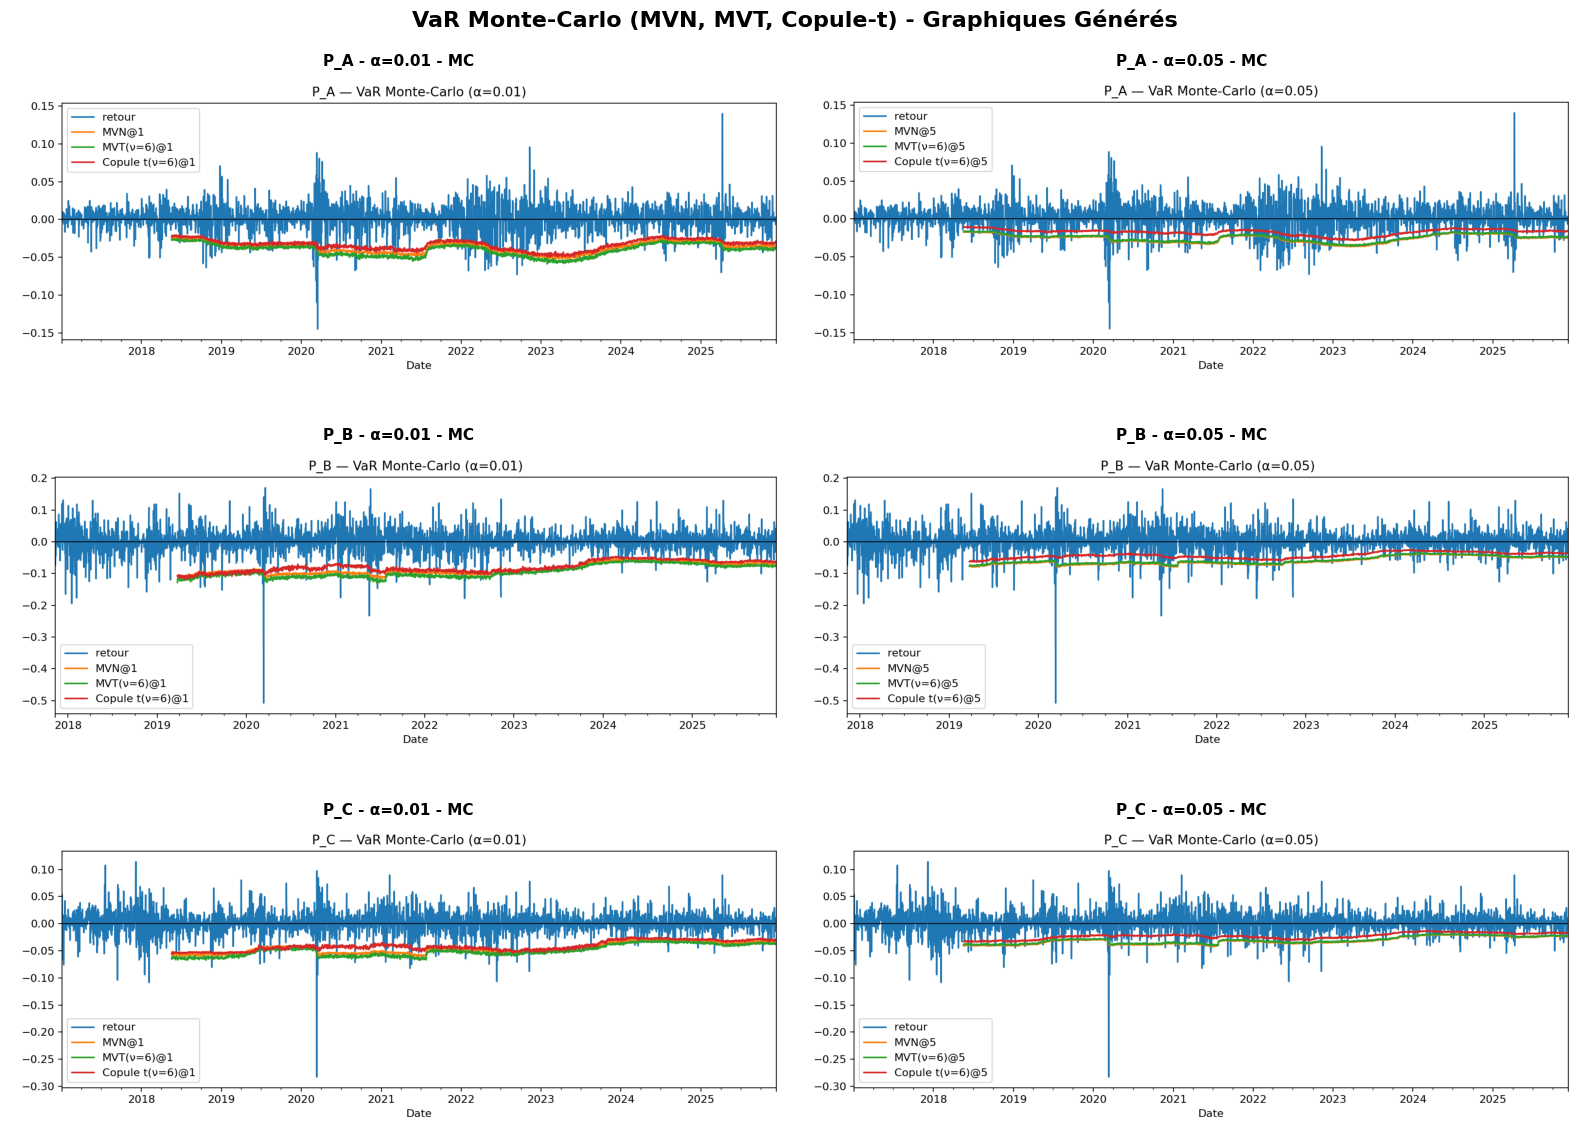


RÉSULTATS DU BACKTESTING MONTE-CARLO


In [13]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Paramètres
RESULTS_DIR = Path("results")
PORTS = ["P_A", "P_B", "P_C"]
ALPHAS = [0.01, 0.05]

# Créer une matrice de graphiques Monte-Carlo
fig, axes = plt.subplots(len(PORTS), len(ALPHAS), figsize=(16, 12))
fig.suptitle('VaR Monte-Carlo (MVN, MVT, Copule-t) - Graphiques Générés',
             fontsize=16, fontweight='bold')

for i, port in enumerate(PORTS):
    for j, alpha in enumerate(ALPHAS):
        ax = axes[i, j]

        # Charger l'image générée par le code Monte-Carlo
        img_file = RESULTS_DIR / f"plot_{port}_MC_a{int(alpha*100)}.png"

        if img_file.exists():
            img = imread(img_file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'{port} - α={alpha} - MC', fontweight='bold', fontsize=11)
        else:
            ax.text(0.5, 0.5, f'Fichier non trouvé:\n{img_file.name}',
                    ha='center', va='center', fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

# Afficher le tableau des résultats Monte-Carlo
print("\n" + "="*90)
print("RÉSULTATS DU BACKTESTING MONTE-CARLO")
print("="*90)



# 5 Méthodes ML : Régression quantile linéaire, GBM quantile.

In [14]:
# 07_gbm_quantile_var.py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.ensemble import GradientBoostingRegressor

# ------------------------------
# Paramètres
# ------------------------------
DATA_RET = Path("data/processed/returns_portfolios.csv")
RESULTS  = Path("results")
RESULTS.mkdir(parents=True, exist_ok=True)

PORTS  = ["P_A", "P_B", "P_C"]
ALPHAS = [0.01, 0.05]

LOOKBACK_FEAT = 252      # profondeur max features (~1 an)
TRAIN_LEN     = 750      # fenêtre d'entraînement (~3 ans)
REFIT_EVERY   = 5        # refit tous les N jours
GBM_PARAMS = dict(
    loss="quantile",
    n_estimators=300,     # ↑ si rapide (500), ↓ si lent (200)
    learning_rate=0.03,
    max_depth=3,
    subsample=0.7,
    max_features=None,
    random_state=42
)
EPS = 1e-12

# ------------------------------
# Tests de backtest
# ------------------------------
def kupiec_pof(breaches: pd.Series, alpha: float):
    T = len(breaches)
    x = int(breaches.sum())
    p_hat = min(max(x / max(T, 1), EPS), 1-EPS)
    lr_uc = -2.0 * (
        (T - x) * np.log(1 - alpha + EPS) + x * np.log(alpha + EPS)
        - ((T - x) * np.log(1 - p_hat + EPS) + x * np.log(p_hat + EPS))
    )
    pval = 1 - chi2.cdf(lr_uc, df=1)
    return lr_uc, pval, x, T

def christoffersen_independence(breaches: pd.Series):
    b = breaches.astype(int).values
    if len(b) < 2:
        return np.nan, np.nan
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(b)):
        p, c = b[i-1], b[i]
        if   p == 0 and c == 0:
            n00 += 1
        elif p == 0 and c == 1:
            n01 += 1
        elif p == 1 and c == 0:
            n10 += 1
        else:
            n11 += 1
    n0, n1 = n00 + n01, n10 + n11
    pi0 = n01 / n0 if n0 > 0 else 0.0
    pi1 = n11 / n1 if n1 > 0 else 0.0
    pi  = (n01 + n11) / max(n0 + n1, 1)
    # Correction: ajout des exposants manquants
    L_ind = ((1 - pi0 + EPS)**n00) * ((pi0 + EPS)**n01) * ((1 - pi1 + EPS)**n10) * ((pi1 + EPS)**n11)
    L_iid = ((1 - pi + EPS)**(n00 + n10)) * ((pi + EPS)**(n01 + n11))
    lr_ind = -2.0 * np.log(max(L_iid, EPS) / max(L_ind, EPS))
    pval = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, pval

def backtest_series(real_ret: pd.Series, q_pred: pd.Series, alpha: float):
    df = pd.concat({"r": real_ret, "q": q_pred}, axis=1).dropna()
    breaches = (df["r"] < df["q"]).astype(int)
    lr_uc, p_uc, x, T = kupiec_pof(breaches, alpha)
    lr_ind, p_ind = christoffersen_independence(breaches)
    lr_cc = lr_uc + lr_ind
    p_cc = 1 - chi2.cdf(lr_cc, df=2)
    es_real = -df.loc[breaches.astype(bool), "r"].mean() if x > 0 else np.nan
    return {
        "T": T, "breaches": int(x), "hit_rate": x / max(T, 1),
        "Kupiec_p": p_uc, "Christoff_p": p_ind, "Joint_p": p_cc,
        "ES_realised": es_real
    }

# ------------------------------
# Features (identiques à l'étape 6)
# ------------------------------
def make_features(r: pd.Series) -> pd.DataFrame:
    """
    Construit des features retardées pour prédiction de quantiles.
    Toutes les features sont basées sur des valeurs passées (pas de data leakage).
    """
    s = r.copy()
    df = pd.DataFrame(index=s.index)
    # Lags 1..10
    for k in range(1, 11):
        df[f"lag{k}"] = s.shift(k)

    s1 = s.shift(1)
    # Moyennes mobiles
    for w in (5, 21, 63):
        df[f"ma{w}"] = s1.rolling(w).mean()
    # Volat STD roulante
    for w in (5, 21, 63):
        df[f"std{w}"] = s1.rolling(w).std(ddof=1)
    # Volat EWMA (lambda 0.94 / 0.97)
    df["ewm_vol_94"] = (s1 - s1.ewm(alpha=0.06, adjust=False).mean())**2
    df["ewm_vol_94"] = np.sqrt(df["ewm_vol_94"].ewm(alpha=0.06, adjust=False).mean())
    df["ewm_vol_97"] = (s1 - s1.ewm(alpha=0.03, adjust=False).mean())**2
    df["ewm_vol_97"] = np.sqrt(df["ewm_vol_97"].ewm(alpha=0.03, adjust=False).mean())
    # |r| et r^2 moyens
    for w in (5, 21, 63):
        df[f"mean_abs_{w}"] = s1.abs().rolling(w).mean()
        df[f"mean_sq_{w}"]  = (s1**2).rolling(w).mean()
    # Quantiles roulants (signal de queue)
    for w in (63, 126, 252):
        df[f"q05_{w}"] = s1.rolling(w).quantile(0.05)
        df[f"q01_{w}"] = s1.rolling(w).quantile(0.01)
    return df.replace([np.inf, -np.inf], np.nan)

def zscore_fit(X: pd.DataFrame):
    """Calcule mean et std pour normalisation."""
    mu = X.mean(axis=0)
    sigma = X.std(axis=0).replace(0, 1e-8)
    return mu, sigma

def zscore_apply(X: pd.DataFrame, mu: pd.Series, sigma: pd.Series):
    """Applique la normalisation z-score."""
    return (X - mu) / sigma

# ------------------------------
# Entraînement roulant GBM quantile
# ------------------------------
def rolling_gbm_quantile(r: pd.Series, alphas, lookback_feat=LOOKBACK_FEAT,
                        train_len=TRAIN_LEN, refit_every=REFIT_EVERY):
    """
    Entraîne un GradientBoostingRegressor en mode quantile pour chaque alpha.
    Utilise une fenêtre glissante avec refit périodique.
    """
    X_all = make_features(r)
    y_all = r.copy()

    # On commence après lookback des features
    X_all = X_all.iloc[lookback_feat:].copy()
    y_all = y_all.loc[X_all.index]
    idx = X_all.index

    start_i = train_len
    cols = [f"q_GBM_{int(a*100)}" for a in alphas]
    out = pd.DataFrame(index=idx[start_i:], columns=cols, dtype=float)

    models = {a: None for a in alphas}
    mu = sigma = None
    last_refit = None

    for i in range(start_i, len(idx)):
        # Refit périodique
        if (last_refit is None) or ((i - last_refit) >= refit_every):
            print(f"  [Refit] Position {i}/{len(idx)} ({i/len(idx)*100:.1f}%)", end='\r')
            tr_idx = idx[i - train_len:i]
            X_tr = X_all.loc[tr_idx]
            y_tr = y_all.loc[tr_idx]

            mu, sigma = zscore_fit(X_tr)
            X_tr_z = zscore_apply(X_tr, mu, sigma).fillna(0.0).to_numpy()

            for a in alphas:
                gbm = GradientBoostingRegressor(**GBM_PARAMS)
                gbm.set_params(alpha=a)  # quantile cible
                gbm.fit(X_tr_z, y_tr.to_numpy())
                models[a] = gbm

            last_refit = i

        # Prédiction t
        X_te = X_all.iloc[[i]]
        X_te_z = zscore_apply(X_te, mu, sigma).fillna(0.0).to_numpy()
        for a in alphas:
            out.iloc[i - start_i, out.columns.get_loc(f"q_GBM_{int(a*100)}")] = models[a].predict(X_te_z)[0]

    print()  # Nouvelle ligne après la barre de progression
    return out

# ------------------------------
# Main
# ------------------------------
def main():
    rets = pd.read_csv(DATA_RET, index_col=0, parse_dates=True)[PORTS].dropna(how="any")
    summaries = []

    for port in PORTS:
        print(f"\n[Traitement] {port}...")
        r = rets[port].copy()
        preds = rolling_gbm_quantile(r, ALPHAS)
        preds.to_csv(RESULTS / f"var_preds_{port}_GBM.csv")

        for a in ALPHAS:
            name = f"q_GBM_{int(a*100)}"
            res = backtest_series(r, preds[name], a)
            res.update({"portfolio": port, "alpha": a, "model": "GBM-Quantile"})
            summaries.append(res)

            # Plot
            fig, ax = plt.subplots(figsize=(10, 4))
            r.plot(ax=ax, label="retour")
            preds[name].plot(ax=ax, label=f"GBM@{int(a*100)}")
            ax.axhline(0, lw=0.8, color="k")
            ax.set_title(f"{port} — VaR par GBM Quantile (α={a})")
            ax.legend()
            fig.tight_layout()
            fig.savefig(RESULTS / f"plot_{port}_GBM_a{int(a*100)}.png", dpi=160)
            plt.close(fig)

    df_sum = pd.DataFrame(summaries).sort_values(["portfolio", "alpha"]).reset_index(drop=True)
    df_sum.to_csv(RESULTS / "backtest_summary_GBM.csv", index=False)

    print("\n=== Résumé Backtests GBM Quantile ===")
    print(df_sum[["portfolio", "alpha", "model", "T", "breaches", "hit_rate",
                  "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]]
          .to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

if __name__ == "__main__":
    main()


[Traitement] P_A...


[Traitement] P_B...


[Traitement] P_C...


=== Résumé Backtests GBM Quantile ===
portfolio  alpha        model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100 GBM-Quantile 1952        48    0.0246    0.0000       1.0000   0.0000       0.0468
      P_A 0.0500 GBM-Quantile 1952       140    0.0717    0.0000       1.0000   0.0002       0.0339
      P_B 0.0100 GBM-Quantile 1952        54    0.0277    0.0000       1.0000   0.0000       0.0904
      P_B 0.0500 GBM-Quantile 1952       136    0.0697    0.0002       1.0000   0.0008       0.0699
      P_C 0.0100 GBM-Quantile 1952        42    0.0215    0.0000       1.0000   0.0001       0.0480
      P_C 0.0500 GBM-Quantile 1952       127    0.0651    0.0035       1.0000   0.0139       0.0353


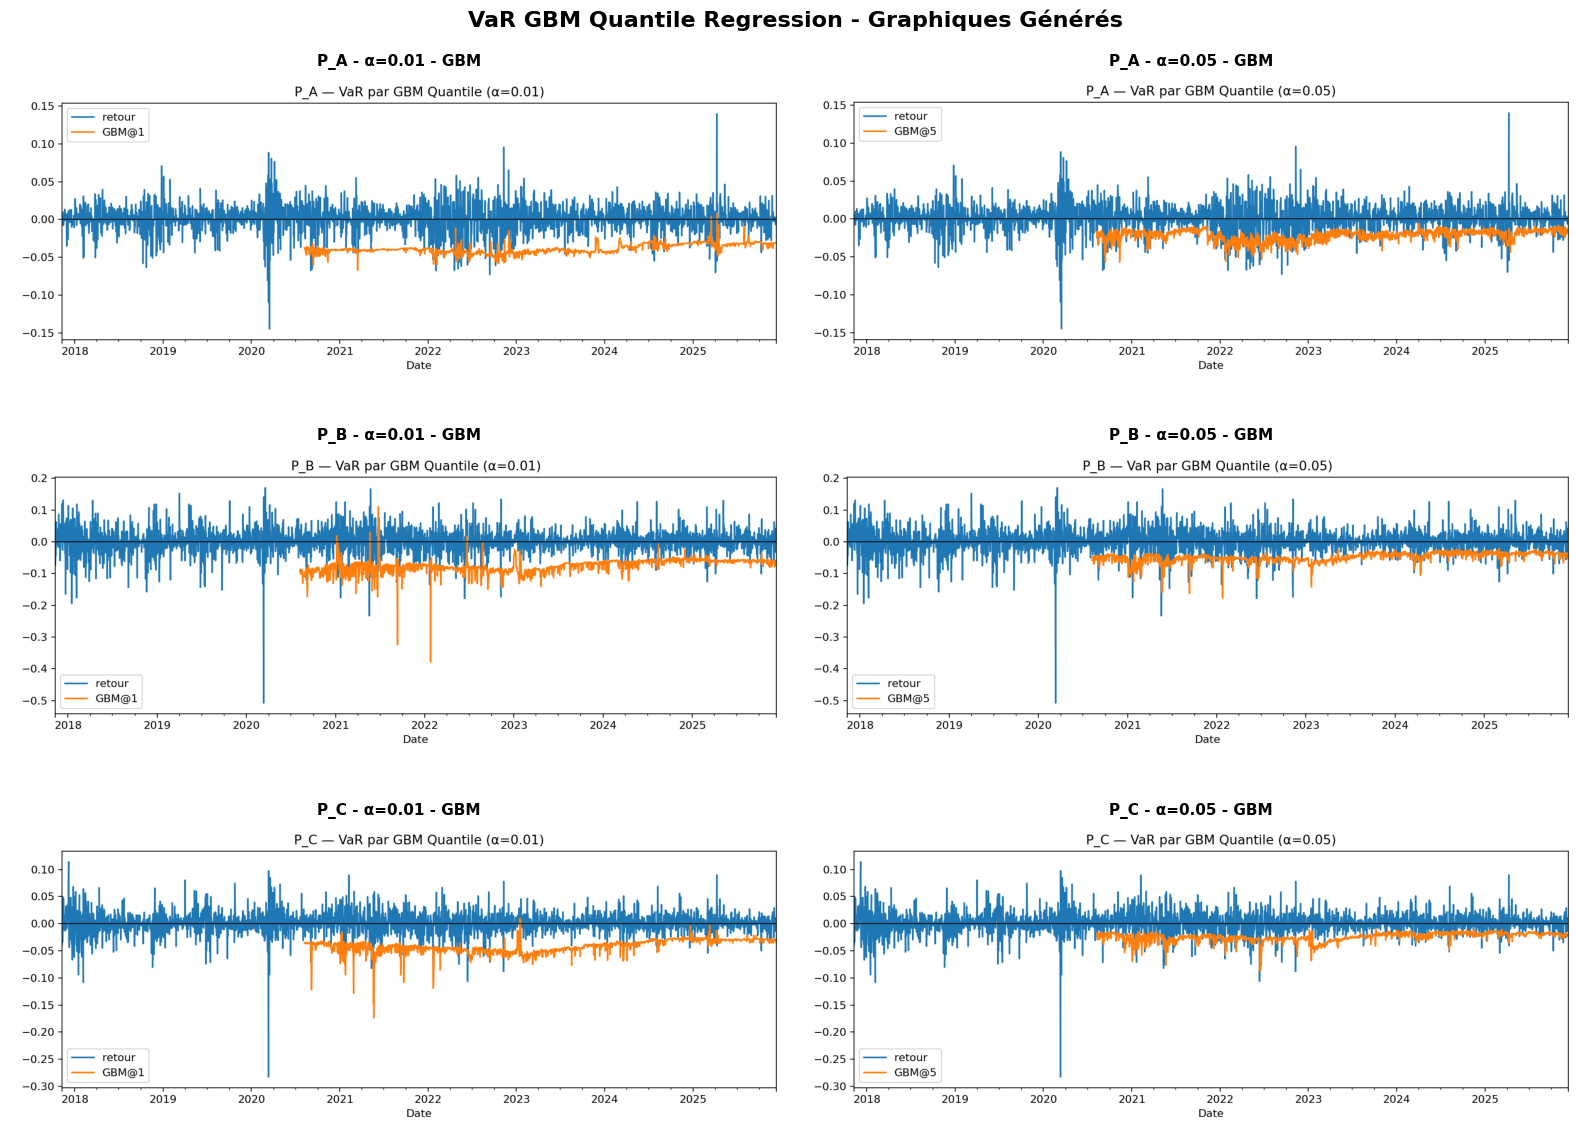


RÉSULTATS DU BACKTESTING GBM QUANTILE REGRESSION
portfolio  alpha        model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100 GBM-Quantile 1952        48    0.0246    0.0000       1.0000   0.0000       0.0468
      P_A 0.0500 GBM-Quantile 1952       140    0.0717    0.0000       1.0000   0.0002       0.0339
      P_B 0.0100 GBM-Quantile 1952        54    0.0277    0.0000       1.0000   0.0000       0.0904
      P_B 0.0500 GBM-Quantile 1952       136    0.0697    0.0002       1.0000   0.0008       0.0699
      P_C 0.0100 GBM-Quantile 1952        42    0.0215    0.0000       1.0000   0.0001       0.0480
      P_C 0.0500 GBM-Quantile 1952       127    0.0651    0.0035       1.0000   0.0139       0.0353


In [15]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Paramètres
RESULTS_DIR = Path("results")
PORTS = ["P_A", "P_B", "P_C"]
ALPHAS = [0.01, 0.05]

# Créer une matrice de graphiques GBM
fig, axes = plt.subplots(len(PORTS), len(ALPHAS), figsize=(16, 12))
fig.suptitle('VaR GBM Quantile Regression - Graphiques Générés',
             fontsize=16, fontweight='bold')

for i, port in enumerate(PORTS):
    for j, alpha in enumerate(ALPHAS):
        ax = axes[i, j]

        # Charger l'image générée par le code GBM
        img_file = RESULTS_DIR / f"plot_{port}_GBM_a{int(alpha*100)}.png"

        if img_file.exists():
            img = imread(img_file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'{port} - α={alpha} - GBM', fontweight='bold', fontsize=11)
        else:
            ax.text(0.5, 0.5, f'Fichier non trouvé:\n{img_file.name}',
                    ha='center', va='center', fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

# Afficher le tableau des résultats GBM
print("\n" + "="*80)
print("RÉSULTATS DU BACKTESTING GBM QUANTILE REGRESSION")
print("="*80)

summary_file = RESULTS_DIR / "backtest_summary_GBM.csv"
if summary_file.exists():
    import pandas as pd
    summary = pd.read_csv(summary_file)
    cols = ["portfolio", "alpha", "model", "T", "breaches", "hit_rate",
            "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]
    print(summary[cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
else:
    print("Fichier backtest_summary_GBM.csv non trouvé!")

# 5-2 quantile_regression

# Formules Mathématiques - Régression Quantile

## 1. Régression Quantile Linéaire

### Objectif
Modéliser directement le quantile conditionnel $q_\alpha(t)$ en fonction de features $\mathbf{X}_t$ :

$$q_\alpha(t) = \mathbf{X}_t^T \boldsymbol{\beta}_\alpha$$

**Où :**
- $q_\alpha(t)$ : quantile conditionnel au niveau $\alpha$
- $\mathbf{X}_t$ : vecteur de features (basé sur $r_{t-1}, r_{t-2}, \ldots$)
- $\boldsymbol{\beta}_\alpha$ : coefficients du modèle pour le quantile $\alpha$

---

## 2. Fonction de Perte (Check Loss)

### Définition
$$\rho_\alpha(u) = u \cdot (\alpha - \mathbb{1}_{u < 0})$$

**Où :**
- $u = r_t - q_\alpha(t)$ : résidu
- $\mathbb{1}_{u < 0}$ : indicatrice ($1$ si $u < 0$, $0$ sinon)

### Forme explicite
$$\rho_\alpha(u) = \begin{cases}
\alpha \cdot u & \text{si } u \geq 0 \\
(\alpha - 1) \cdot u & \text{si } u < 0
\end{cases}$$

**Asymétrie :** Pénalise davantage les sous-estimations (si $\alpha$ petit) ou les surestimations (si $\alpha$ grand).

---

## 3. Optimisation

### Problème à résoudre
$$\min_{\boldsymbol{\beta}_\alpha} \sum_{t=1}^{T} \rho_\alpha(r_t - \mathbf{X}_t^T \boldsymbol{\beta}_\alpha) + \lambda \|\boldsymbol{\beta}_\alpha\|_1$$

**Où :**
- $\lambda$ : paramètre de régularisation L1 (dans le code : $\lambda = 10^{-4}$)
- $\|\boldsymbol{\beta}_\alpha\|_1$ : norme L1 pour sélection de variables

**Méthode :** Programmation linéaire (solveur `highs` dans scikit-learn).

---

## 4. Construction des Features

### Rendements retardés (Lags)
$$X_t^{(lag\,k)} = r_{t-k}, \quad k = 1, 2, \ldots, 10$$

---

### Moyennes mobiles
$$X_t^{(ma\,w)} = \frac{1}{w} \sum_{j=1}^{w} r_{t-j}, \quad w \in \{5, 21, 63\}$$

---

### Volatilité (écart-type roulant)
$$X_t^{(std\,w)} = \sqrt{\frac{1}{w-1} \sum_{j=1}^{w} (r_{t-j} - \bar{r}_{t,w})^2}, \quad w \in \{5, 21, 63\}$$

---

### Volatilité EWMA (Exponentially Weighted Moving Average)
$$\sigma_t^{EWMA} = \sqrt{\lambda \sigma_{t-1}^{2} + (1-\lambda)(r_{t-1} - \mu_{t-1})^2}$$

**Paramètres utilisés :**
- $\lambda = 0.94$ : `ewm_vol_94`
- $\lambda = 0.97$ : `ewm_vol_97`

---

### Moyennes de valeurs absolues et carrées
$$X_t^{(mean\\_abs\,w)} = \frac{1}{w} \sum_{j=1}^{w} |r_{t-j}|, \quad w \in \{5, 21, 63\}$$

$$X_t^{(mean\\_sq\,w)} = \frac{1}{w} \sum_{j=1}^{w} r_{t-j}^2, \quad w \in \{5, 21, 63\}$$

---

### Quantiles empiriques roulants
$$X_t^{(q\,p\,w)} = \text{Quantile}_p\{r_{t-1}, r_{t-2}, \ldots, r_{t-w}\}$$

**Dans le code :**
- $p = 0.05, w \in \{63, 126, 252\}$ : `q05_63`, `q05_126`, `q05_252`
- $p = 0.01, w \in \{63, 126, 252\}$ : `q01_63`, `q01_126`, `q01_252`

---

## 5. Normalisation (Z-score)

### Estimation sur données d'entraînement
$$\mu_j = \frac{1}{T_{train}} \sum_{t \in train} X_{t,j}$$

$$\sigma_j = \sqrt{\frac{1}{T_{train}-1} \sum_{t \in train} (X_{t,j} - \mu_j)^2}$$

### Application
$$\tilde{X}_{t,j} = \frac{X_{t,j} - \mu_j}{\sigma_j}$$

**Important :** $\mu$ et $\sigma$ sont calculés uniquement sur l'ensemble d'entraînement pour éviter le data leakage.

---

## 6. Stratégie de Rolling Window

### Fenêtre d'entraînement
$$T_{train} = 750 \text{ jours} \approx 3 \text{ ans de trading}$$

### Refit périodique
- **Refit complet** : tous les `refit_every = 5` jours
- **Prédiction** : entre les refits, utiliser le modèle actuel

**Avantages :**
- Réduit le temps de calcul
- Adaptation progressive aux changements de marché

---

## 7. Prédiction 1-step ahead

### À la date $t$
$$\hat{q}_\alpha(t) = \tilde{\mathbf{X}}_t^T \boldsymbol{\beta}_\alpha$$

**Où :**
- $\tilde{\mathbf{X}}_t$ : features normalisées à la date $t$
- $\boldsymbol{\beta}_\alpha$ : coefficients estimés sur fenêtre $[t-750, t-1]$

---

## 8. Tests de Backtesting

### Dépassements
$$I_t = \mathbb{1}\{r_t < \hat{q}_{\alpha}(t)\}$$

$$X = \sum_{t=1}^{T} I_t$$

---

### Test de Kupiec
$$LR_{UC} = -2 \left[ (T-X)\ln(1-\alpha) + X\ln(\alpha) - (T-X)\ln(1-\hat{p}) - X\ln(\hat{p}) \right]$$

**Où :** $\hat{p} = X/T$

**Distribution :** $LR_{UC} \sim \chi^2(1)$

---

### Test de Christoffersen
$$LR_{IND} = -2\ln\left(\frac{L_{iid}}{L_{ind}}\right)$$

**Où :**
$$L_{ind} = (1-\pi_0)^{n_{00}} \cdot \pi_0^{n_{01}} \cdot (1-\pi_1)^{n_{10}} \cdot \pi_1^{n_{11}}$$

$$L_{iid} = (1-\pi)^{n_{00}+n_{10}} \cdot \pi^{n_{01}+n_{11}}$$

**Distribution :** $LR_{IND} \sim \chi^2(1)$

---

### Test Conjoint
$$LR_{CC} = LR_{UC} + LR_{IND} \sim \chi^2(2)$$

---

## 9. Expected Shortfall (ES)

$$\widehat{ES}_\alpha = -\frac{1}{X}\sum_{t : r_t < \hat{q}_{\alpha}(t)} r_t$$

---

## 10. Paramètres du Code

| Paramètre | Valeur | Description |
|-----------|--------|-------------|
| `LOOKBACK_FEAT` | 252 | Profondeur max des features (≈1 an) |
| `TRAIN_LEN` | 750 | Fenêtre d'entraînement (≈3 ans) |
| `REFIT_EVERY` | 5 | Refit tous les 5 jours |
| `QR_ALPHA` | $10^{-4}$ | Régularisation L1 |
| $\alpha$ | 0.01, 0.05 | Niveaux de VaR (1%, 5%) |
| Solver | `highs` | Méthode d'optimisation |

---

## 11. Avantages de la Régression Quantile

✅ **Non-paramétrique** : Pas d'hypothèse de distribution  
✅ **Adaptative** : S'ajuste aux conditions de marché  
✅ **Robuste** : Moins sensible aux outliers que la régression ordinaire  
✅ **Interprétable** : Coefficients $\boldsymbol{\beta}_\alpha$ identifient les drivers du risque  
✅ **Flexible** : Peut incorporer des features complexes

---

## 12. Workflow du Code

```
1. Charger les rendements r_t
2. Pour chaque portefeuille :
   a) Construire les features X_t (basées sur r_{t-1}, r_{t-2}, ...)
   b) Pour t = TRAIN_LEN, ..., T :
      - Si (t - last_refit) ≥ 5 :
          * Entraîner sur [t-750, t-1] :
            - Normaliser : (X - μ) / σ
            - Pour chaque α :
              * Minimiser : Σ ρ_α(r_i - X_i^T β_α) + λ||β_α||_1
          * Sauvegarder modèles et (μ, σ)
      - Prédire : q̂_α(t) = X_t^T β_α
   c) Backtest (Kupiec, Christoffersen, ES)
   d) Sauvegarder résultats et graphiques
```

---

## Références

- Koenker, R., & Bassett, G. (1978). "Regression Quantiles"
- Koenker, R. (2005). "Quantile Regression" (Cambridge University Press)
- Taylor, J. W. (2019). "Forecasting Value at Risk and Expected Shortfall Using a Semiparametric Approach Based on the Asymmetric Laplace Distribution"

In [16]:
# 06_quantile_regression_var.py
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2
from sklearn.linear_model import QuantileRegressor

# ------------------------------
# Paramètres globaux
# ------------------------------
DATA_RET = Path("data/processed/returns_portfolios.csv")
RESULTS = Path("results")
RESULTS.mkdir(parents=True, exist_ok=True)

PORTS  = ["P_A", "P_B", "P_C"]        # portefeuilles
ALPHAS = [0.01, 0.05]                 # niveaux VaR
LOOKBACK_FEAT = 252                   # profondeur max pour features (≈ 1 an)
TRAIN_LEN = 750                       # taille fenêtre d'entraînement (≈ 3 ans)
REFIT_EVERY = 5                       # refit tous les N jours (compromis vitesse/qualité)
QR_ALPHA = 1e-4                       # régularisation L1 du QuantileRegressor (faible)
EPS = 1e-12

# ------------------------------
# Tests de backtest
# ------------------------------
def kupiec_pof(breaches: pd.Series, alpha: float):
    T = len(breaches)
    x = int(breaches.sum())
    p_hat = min(max(x / max(T, 1), EPS), 1-EPS)
    lr_uc = -2.0 * (
        (T - x) * np.log(1 - alpha + EPS) + x * np.log(alpha + EPS)
        - ((T - x) * np.log(1 - p_hat + EPS) + x * np.log(p_hat + EPS))
    )
    pval = 1 - chi2.cdf(lr_uc, df=1)
    return lr_uc, pval, x, T

def christoffersen_independence(breaches: pd.Series):
    b = breaches.astype(int).values
    if len(b) < 2:
        return np.nan, np.nan
    n00 = n01 = n10 = n11 = 0
    for i in range(1, len(b)):
        p, c = b[i-1], b[i]
        if   p == 0 and c == 0:
            n00 += 1
        elif p == 0 and c == 1:
            n01 += 1
        elif p == 1 and c == 0:
            n10 += 1
        else:
            n11 += 1
    n0, n1 = n00 + n01, n10 + n11
    pi0 = n01 / n0 if n0 > 0 else 0.0
    pi1 = n11 / n1 if n1 > 0 else 0.0
    pi  = (n01 + n11) / max(n0 + n1, 1)
    # Correction: ajout des exposants manquants
    L_ind = ((1 - pi0 + EPS)**n00) * ((pi0 + EPS)**n01) * ((1 - pi1 + EPS)**n10) * ((pi1 + EPS)**n11)
    L_iid = ((1 - pi + EPS)**(n00 + n10)) * ((pi + EPS)**(n01 + n11))
    lr_ind = -2.0 * np.log(max(L_iid, EPS) / max(L_ind, EPS))
    pval = 1 - chi2.cdf(lr_ind, df=1)
    return lr_ind, pval

def backtest_series(real_ret: pd.Series, q_pred: pd.Series, alpha: float):
    df = pd.concat({"r": real_ret, "q": q_pred}, axis=1).dropna()
    breaches = (df["r"] < df["q"]).astype(int)
    lr_uc, p_uc, x, T = kupiec_pof(breaches, alpha)
    lr_ind, p_ind = christoffersen_independence(breaches)
    lr_cc = lr_uc + lr_ind
    p_cc = 1 - chi2.cdf(lr_cc, df=2)
    es_real = -df.loc[breaches.astype(bool), "r"].mean() if x > 0 else np.nan
    return {
        "T": T, "breaches": int(x), "hit_rate": x / max(T, 1),
        "Kupiec_p": p_uc, "Christoff_p": p_ind, "Joint_p": p_cc,
        "ES_realised": es_real
    }

# ------------------------------
# Construction des features X_t (basées sur r_{t-1}, r_{t-2}, …)
# ------------------------------
def make_features(r: pd.Series) -> pd.DataFrame:
    """
    Construit des features purement 'retardées' (pas de fuite d'info) :
    - lags 1..10
    - moyennes mobiles 5, 21, 63 (sur r.shift(1))
    - volat std roulante 5, 21, 63
    - volat EWMA (lambda=0.94 et 0.97)
    - puissances/abs (moyennes de |r|, r^2)
    - quantiles empiriques roulants (5% et 1%)
    Tout est calculé à partir de r.shift(1) pour ne pas inclure r_t.
    """
    s = r.copy()
    df = pd.DataFrame(index=s.index)

    # Lags
    for k in range(1, 11):
        df[f"lag{k}"] = s.shift(k)

    s1 = s.shift(1)
    # MM
    for w in (5, 21, 63):
        df[f"ma{w}"] = s1.rolling(w).mean()
    # STD
    for w in (5, 21, 63):
        df[f"std{w}"] = s1.rolling(w).std(ddof=1)
    # EWMA vol (lambda = 0.94, 0.97)
    # pandas ewm alpha = 1-lambda
    df["ewm_vol_94"] = (s1 - s1.ewm(alpha=0.06, adjust=False).mean())**2
    df["ewm_vol_94"] = np.sqrt(df["ewm_vol_94"].ewm(alpha=0.06, adjust=False).mean())
    df["ewm_vol_97"] = (s1 - s1.ewm(alpha=0.03, adjust=False).mean())**2
    df["ewm_vol_97"] = np.sqrt(df["ewm_vol_97"].ewm(alpha=0.03, adjust=False).mean())

    # |r| et r^2 moyens
    for w in (5, 21, 63):
        df[f"mean_abs_{w}"] = s1.abs().rolling(w).mean()
        df[f"mean_sq_{w}"]  = (s1**2).rolling(w).mean()

    # Quantiles roulants (sur s1)
    for w in (63, 126, 252):
        df[f"q05_{w}"] = s1.rolling(w).quantile(0.05)
        df[f"q01_{w}"] = s1.rolling(w).quantile(0.01)

    # Remplacement infinities
    df = df.replace([np.inf, -np.inf], np.nan)
    return df

def zscore_fit(X: pd.DataFrame):
    """Calcule mean et std pour normalisation."""
    mu = X.mean(axis=0)
    sigma = X.std(axis=0).replace(0, 1e-8)
    return mu, sigma

def zscore_apply(X: pd.DataFrame, mu: pd.Series, sigma: pd.Series):
    """Applique la normalisation z-score."""
    return (X - mu) / sigma

# ------------------------------
# Entraînement roulant + prédiction quantiles
# ------------------------------
def rolling_quantile_regression(r: pd.Series, alphas, lookback_feat=LOOKBACK_FEAT,
                                train_len=TRAIN_LEN, refit_every=REFIT_EVERY):
    """
    Retourne DataFrame des quantiles prédits aux dates de test.
    On commence après max(lookback_feat, train_len).
    """
    # Features et cible
    X_all = make_features(r)
    y_all = r.copy()  # y_t
    # Drop lignes initiales incomplètes
    X_all = X_all.iloc[lookback_feat:].copy()
    y_all = y_all.loc[X_all.index]

    # Indice à partir duquel on peut former un premier train
    start_i = train_len
    idx = X_all.index
    cols = [f"q_QR_{int(a*100)}" for a in alphas]
    out = pd.DataFrame(index=idx[start_i:], columns=cols, dtype=float)

    # Modèles pour chaque alpha
    models = {a: None for a in alphas}
    mu = sigma = None
    last_refit = None

    for i in range(start_i, len(idx)):
        # Refit périodique
        if (last_refit is None) or ((i - last_refit) >= refit_every):
            tr_idx = idx[i - train_len:i]
            X_tr = X_all.loc[tr_idx]
            y_tr = y_all.loc[tr_idx]

            # Normalisation (fit sur train uniquement)
            mu, sigma = zscore_fit(X_tr)
            X_tr_z = zscore_apply(X_tr, mu, sigma).fillna(0.0).to_numpy()

            # Entraîner un modèle par alpha
            for a in alphas:
                qr = QuantileRegressor(quantile=a, alpha=QR_ALPHA, solver="highs")
                qr.fit(X_tr_z, y_tr.to_numpy())
                models[a] = qr
            last_refit = i

        # Prédiction pour t = idx[i]
        X_te = X_all.iloc[[i]]
        X_te_z = zscore_apply(X_te, mu, sigma).fillna(0.0).to_numpy()
        for a in alphas:
            out.iloc[i - start_i, out.columns.get_loc(f"q_QR_{int(a*100)}")] = models[a].predict(X_te_z)[0]

    return out

# ------------------------------
# Main
# ------------------------------
def main():
    rets = pd.read_csv(DATA_RET, index_col=0, parse_dates=True)[PORTS].dropna(how="any")

    summaries = []
    for port in PORTS:
        print(f"\n[Traitement] {port}...")
        r = rets[port].copy()
        preds = rolling_quantile_regression(r, ALPHAS)
        preds.to_csv(RESULTS / f"var_preds_{port}_QR.csv")

        # Backtests + plots
        for a in ALPHAS:
            name = f"q_QR_{int(a*100)}"
            res = backtest_series(r, preds[name], a)
            res.update({"portfolio": port, "alpha": a, "model": "QR"})
            summaries.append(res)

            # Plot
            fig, ax = plt.subplots(figsize=(10, 4))
            r.plot(ax=ax, label="retour")
            preds[name].plot(ax=ax, label=f"QR@{int(a*100)}")
            ax.axhline(0, lw=0.8, color="k")
            ax.set_title(f"{port} — VaR par Régression Quantile (α={a})")
            ax.legend()
            fig.tight_layout()
            fig.savefig(RESULTS / f"plot_{port}_QR_a{int(a*100)}.png", dpi=160)
            plt.close(fig)

    df_sum = pd.DataFrame(summaries).sort_values(["portfolio", "alpha"]).reset_index(drop=True)
    df_sum.to_csv(RESULTS / "backtest_summary_QR.csv", index=False)

    print("\n=== Résumé Backtests Régression Quantile ===")
    print(df_sum[["portfolio", "alpha", "model", "T", "breaches", "hit_rate",
                  "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]]
          .to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

if __name__ == "__main__":
    main()


[Traitement] P_A...

[Traitement] P_B...

[Traitement] P_C...

=== Résumé Backtests Régression Quantile ===
portfolio  alpha model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100    QR 1952        98    0.0502    0.0000       1.0000   0.0000       0.0247
      P_A 0.0500    QR 1952       169    0.0866    0.0000       1.0000   0.0000       0.0247
      P_B 0.0100    QR 1952        75    0.0384    0.0000       1.0000   0.0000       0.0559
      P_B 0.0500    QR 1952       125    0.0640    0.0063       1.0000   0.0239       0.0640
      P_C 0.0100    QR 1952        85    0.0435    0.0000       1.0000   0.0000       0.0267
      P_C 0.0500    QR 1952       142    0.0727    0.0000       1.0000   0.0001       0.0294


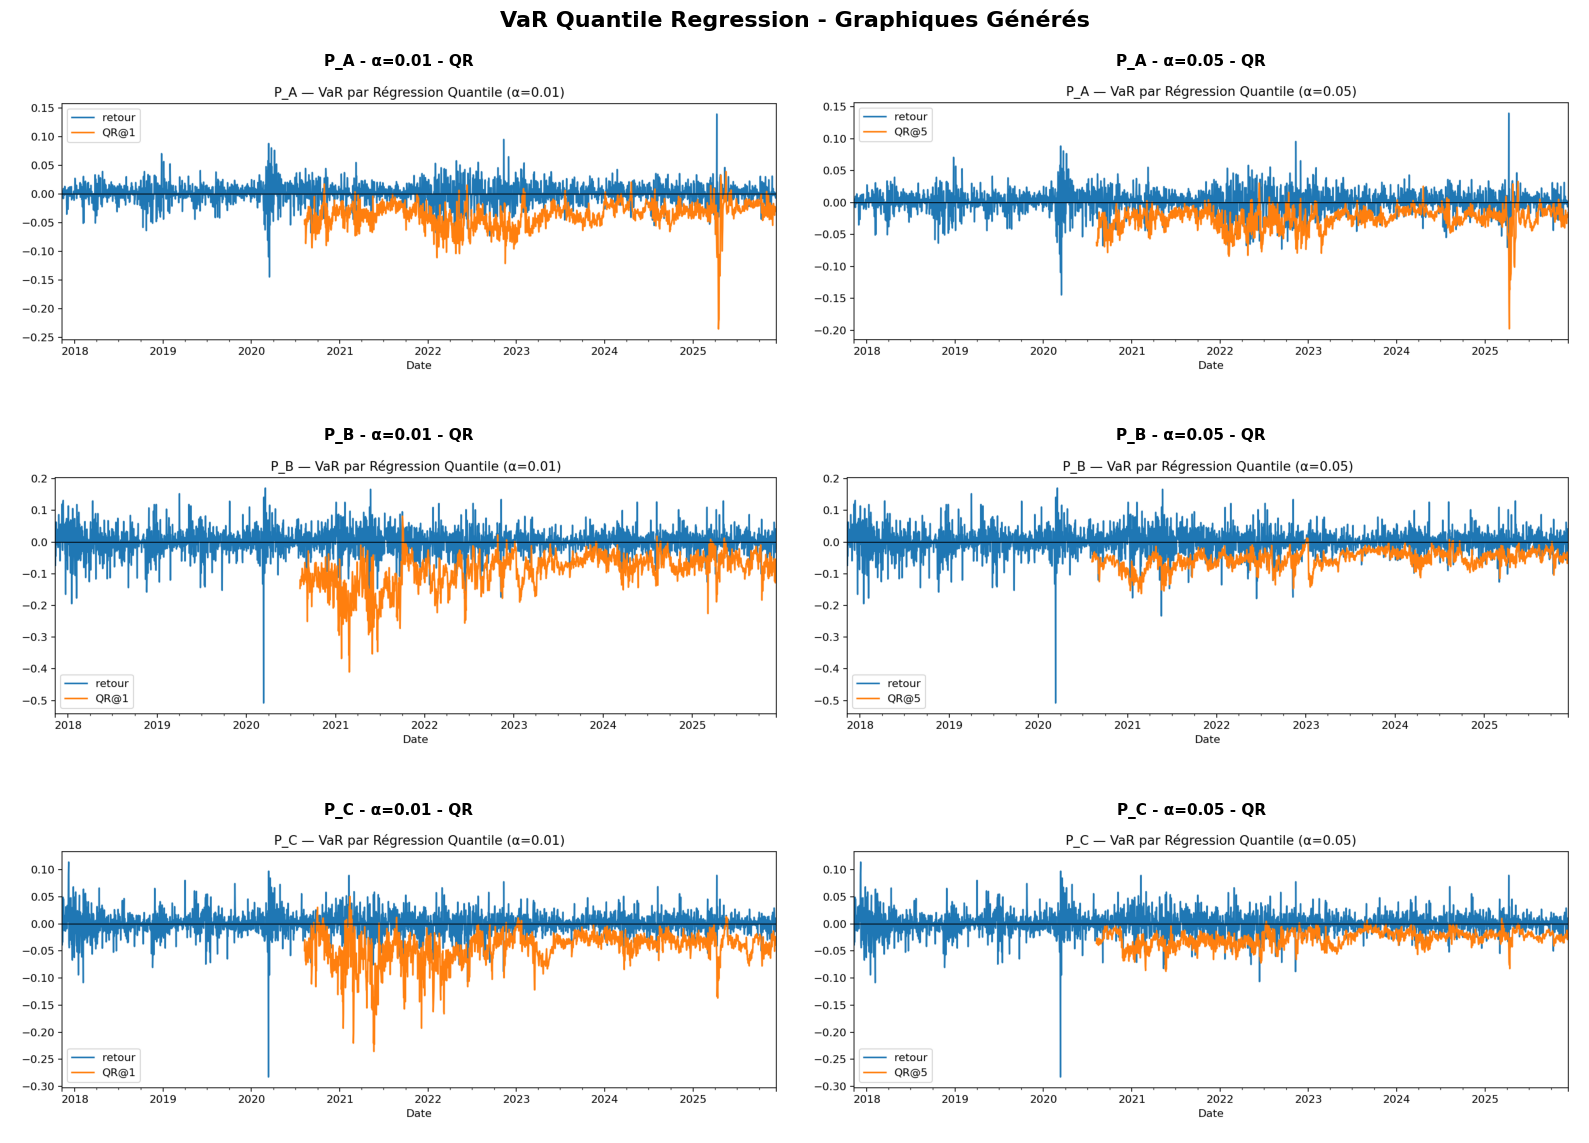


RÉSULTATS DU BACKTESTING QUANTILE REGRESSION
portfolio  alpha model    T  breaches  hit_rate  Kupiec_p  Christoff_p  Joint_p  ES_realised
      P_A 0.0100    QR 1952        98    0.0502    0.0000       1.0000   0.0000       0.0247
      P_A 0.0500    QR 1952       169    0.0866    0.0000       1.0000   0.0000       0.0247
      P_B 0.0100    QR 1952        75    0.0384    0.0000       1.0000   0.0000       0.0559
      P_B 0.0500    QR 1952       125    0.0640    0.0063       1.0000   0.0239       0.0640
      P_C 0.0100    QR 1952        85    0.0435    0.0000       1.0000   0.0000       0.0267
      P_C 0.0500    QR 1952       142    0.0727    0.0000       1.0000   0.0001       0.0294


In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Paramètres
RESULTS_DIR = Path("results")
PORTS = ["P_A", "P_B", "P_C"]
ALPHAS = [0.01, 0.05]

# Créer une matrice de graphiques Quantile Regression
fig, axes = plt.subplots(len(PORTS), len(ALPHAS), figsize=(16, 12))
fig.suptitle('VaR Quantile Regression - Graphiques Générés',
             fontsize=16, fontweight='bold')

for i, port in enumerate(PORTS):
    for j, alpha in enumerate(ALPHAS):
        ax = axes[i, j]

        # Charger l'image générée
        img_file = RESULTS_DIR / f"plot_{port}_QR_a{int(alpha*100)}.png"

        if img_file.exists():
            img = imread(img_file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'{port} - α={alpha} - QR', fontweight='bold', fontsize=11)
        else:
            ax.text(0.5, 0.5, f'Fichier non trouvé:\n{img_file.name}',
                    ha='center', va='center', fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

# Afficher le tableau des résultats
print("\n" + "="*80)
print("RÉSULTATS DU BACKTESTING QUANTILE REGRESSION")
print("="*80)

summary_file = RESULTS_DIR / "backtest_summary_QR.csv"
if summary_file.exists():
    import pandas as pd
    summary = pd.read_csv(summary_file)
    cols = ["portfolio", "alpha", "model", "T", "breaches", "hit_rate",
            "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"]
    print(summary[cols].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
else:
    print("Fichier backtest_summary_QR.csv non trouvé!")

# 6 Comparatif : Classement des modèles selon leurs performances et stabilité.

# Formules Mathématiques - Comparaison des Méthodes VaR

## 1. Déviation du Taux de Dépassement

$$\text{HitDev} = |\hat{p} - \alpha|$$

**Où :** $\hat{p} = X/T$ (taux de dépassement observé), $\alpha$ (niveau VaR théorique)

---

## 2. Zones de Bâle (Traffic Light)

### Distribution binomiale
$$X \sim \text{Binomial}(T, \alpha)$$

### Quantiles binomiaux
$$q_{0.95} = B^{-1}(0.95; T, \alpha)$$
$$q_{0.9999} = B^{-1}(0.9999; T, \alpha)$$

### Classification par zones
$$\text{Zone} = \begin{cases}
\text{Verte} & \text{si } X \leq q_{0.95} \\
\text{Jaune} & \text{si } q_{0.95} < X \leq q_{0.9999} \\
\text{Rouge} & \text{si } X > q_{0.9999}
\end{cases}$$

---

## 3. Système de Classement

### Rang par critère
$$\text{Rank}_i^{(critère)} = \text{rang}(\text{métrique}_i)$$

**Critères :**
1. $\text{Rank}^{Joint}$ : basé sur $p_{Joint}$ (ordre décroissant)
2. $\text{Rank}^{Kupiec}$ : basé sur $p_{Kupiec}$ (ordre décroissant)
3. $\text{Rank}^{HitDev}$ : basé sur $|\hat{p} - \alpha|$ (ordre croissant)
4. $\text{Rank}^{ES}$ : basé sur $\widehat{ES}_\alpha$ (ordre croissant)

### Score agrégé
$$\text{Score}_i = \frac{1}{4}\left(\text{Rank}_i^{Joint} + \text{Rank}_i^{Kupiec} + \text{Rank}_i^{HitDev} + \text{Rank}_i^{ES}\right)$$

---

## 4. Tests Statistiques

### Test de Kupiec
$$LR_{UC} = -2 \left[ (T-X)\ln(1-\alpha) + X\ln(\alpha) - (T-X)\ln(1-\hat{p}) - X\ln(\hat{p}) \right]$$

$$p_{Kupiec} = 1 - F_{\chi^2(1)}(LR_{UC})$$

---

### Test de Christoffersen
$$LR_{IND} = -2\ln\left(\frac{L_{iid}}{L_{ind}}\right)$$

**Où :**
$$L_{ind} = (1-\pi_0)^{n_{00}} \cdot \pi_0^{n_{01}} \cdot (1-\pi_1)^{n_{10}} \cdot \pi_1^{n_{11}}$$
$$L_{iid} = (1-\pi)^{n_{00}+n_{10}} \cdot \pi^{n_{01}+n_{11}}$$

$$p_{Christoffersen} = 1 - F_{\chi^2(1)}(LR_{IND})$$

---

### Test Conjoint
$$LR_{CC} = LR_{UC} + LR_{IND}$$

$$p_{Joint} = 1 - F_{\chi^2(2)}(LR_{CC})$$

---

## 5. Expected Shortfall Réalisée

$$\widehat{ES}_\alpha = -\frac{1}{X}\sum_{t : r_t < q_{\alpha,t}} r_t$$

---

## 6. Sélection du Meilleur Modèle

$$\text{Winner} = \arg\min_{i} \text{Score}_i$$

In [18]:
# 06_compare_all_methods.py
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom

RESULTS = Path("results")
RESULTS.mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def read_safe(path):
    if Path(path).exists():
        return pd.read_csv(path)
    print(f"[WARN] Fichier manquant : {path}")
    return pd.DataFrame()

def nice_model_name(s: str) -> str:
    """Normalise les noms de modèles selon l'étape."""
    s0 = str(s)
    # Étape 2 (déjà propres)
    if s0 in {"HS", "VC", "VC_EWMA"}:
        return s0
    # Étape 3
    if "GARCH" in s0:
        return s0.replace("GARCH(1,1)-t", "GARCH(1,1)-t")
    # Étape 4
    if s0.startswith("q_MVN_"):
        return "MC-MVN"
    if s0.startswith("q_MVT"):
        m = re.search(r"q_MVT(\d+)_", s0)
        nu = m.group(1) if m else "?"
        return f"MC-MVT(ν={nu})"
    if s0.startswith("q_COPt"):
        m = re.search(r"q_COPt(\d+)_", s0)
        nu = m.group(1) if m else "?"
        return f"Copule-t(ν={nu})"
    return s0

def basel_zone(T: int, alpha: float, breaches: int):
    """
    Généralisation 'traffic-light' Basel via quantiles binomiaux.
    Vert : x ≤ q95 ; Jaune : q95 < x ≤ q99.99 ; Rouge : x > q99.99
    (reproduit ~ 4/9 exceptions pour T=250, α=1%).
    """
    if T is None or T <= 0:
        return "NA"
    q95   = int(binom.ppf(0.95,   T, alpha))
    q9999 = int(binom.ppf(0.9999, T, alpha))
    if breaches <= q95:
        return "green"
    elif breaches <= q9999:
        return "yellow"
    else:
        return "red"

def color_for_zone(zone: str):
    return {"green": "#2ca02c", "yellow": "#ffbf00", "red": "#d62728"}.get(zone, "#7f7f7f")

# ---------- Load & unify ----------
df2 = read_safe(RESULTS / "backtest_summary.csv")          # HS, VC, VC_EWMA
df3 = read_safe(RESULTS / "backtest_summary_GARCH.csv")    # GARCH
df4 = read_safe(RESULTS / "backtest_summary_MC.csv")       # MVN/MVT/Copule-t

df = pd.concat([df2, df3, df4], ignore_index=True)
if df.empty:
    raise SystemExit("Aucun résultat trouvé. Lance d'abord les étapes 2–4.")

needed = {"portfolio", "alpha", "model", "T", "breaches", "hit_rate",
          "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised"}
missing = needed - set(df.columns)
if missing:
    raise SystemExit(f"Colonnes manquantes: {missing}")

# Noms propres
df["model"] = df["model"].apply(nice_model_name)
# Tri, types
df["alpha"] = df["alpha"].astype(float)
df["T"] = df["T"].astype(int)
df["breaches"] = df["breaches"].astype(int)

# Métriques dérivées
df["hit_dev_abs"] = (df["hit_rate"] - df["alpha"]).abs()
df["zone"] = [basel_zone(T, a, x) for T, a, x in zip(df["T"], df["alpha"], df["breaches"])]

# ---------- Classement par (portfolio, alpha) ----------
def rank_group(g: pd.DataFrame):
    """Rangs (plus petit = meilleur)."""
    r_joint = g["Joint_p"].rank(ascending=False, method="min")
    r_kup   = g["Kupiec_p"].rank(ascending=False, method="min")
    r_hit   = g["hit_dev_abs"].rank(ascending=True,  method="min")
    # ES plus faible = mieux (pertes plus petites lors des breaches)
    r_es    = g["ES_realised"].rank(ascending=True,  method="min", na_option="keep")
    score   = (r_joint + r_kup + r_hit + r_es) / 4.0
    out = g.copy()
    out["rank_joint"] = r_joint
    out["rank_kupiec"] = r_kup
    out["rank_hitdev"] = r_hit
    out["rank_es"] = r_es
    out["rank_avg"] = score
    out = out.sort_values(["rank_avg", "Joint_p"], ascending=[True, False])
    return out

ranked = (df.groupby(["portfolio", "alpha"], group_keys=False)
            .apply(rank_group)
            .reset_index(drop=True))

# Sauvegardes
df.to_csv(RESULTS / "compare_all_methods_raw.csv", index=False)
ranked.to_csv(RESULTS / "compare_all_methods_ranked.csv", index=False)

# Winners par groupe
winners = (ranked.groupby(["portfolio", "alpha"], as_index=False)
                  .first()[["portfolio", "alpha", "model", "rank_avg", "zone",
                           "Kupiec_p", "Christoff_p", "Joint_p", "ES_realised",
                           "breaches", "T", "hit_rate"]]
                  .rename(columns={"model": "winner_model"}))
winners.to_csv(RESULTS / "winners_by_portfolio_alpha.csv", index=False)

print("\n=== TOP modèles par (portfolio, α) ===")
print(winners.to_string(index=False, float_format=lambda x: f"{x:0.4f}"))

# ---------- Plots (optionnels) ----------
def plot_group_table(g: pd.DataFrame):
    """Génère un graphique de comparaison pour un groupe."""
    name = f"{g['portfolio'].iloc[0]}_a{int(g['alpha'].iloc[0]*100)}"
    fig, ax = plt.subplots(figsize=(10, 4.5))
    # Barres : Joint_p
    order = g.sort_values(["rank_avg", "Joint_p"], ascending=[True, False])
    y = order["Joint_p"].values
    labels = order["model"].values
    colors = [color_for_zone(z) for z in order["zone"].values]
    ax.bar(range(len(y)), y, tick_label=labels, color=colors)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Joint p-value (↑ mieux)")
    ax.set_title(f"{name} — Comparatif méthodes (couleur = zone Basel)")
    for i, (p, r) in enumerate(zip(y, order["rank_avg"].values)):
        # Gérer les NaN dans le rank
        rank_text = f"rk {int(r)}" if not np.isnan(r) else "rk N/A"
        ax.text(i, p + 0.02, rank_text, ha="center", va="bottom", fontsize=8, rotation=0)
    fig.tight_layout()
    fig.savefig(RESULTS / f"compare_{name}.png", dpi=160)
    plt.close(fig)

for (p, a), g in ranked.groupby(["portfolio", "alpha"]):
    plot_group_table(g)

print(f"\nFichiers générés dans {RESULTS.resolve()}:")
print(" - compare_all_methods_raw.csv")
print(" - compare_all_methods_ranked.csv")
print(" - winners_by_portfolio_alpha.csv")
print(" - compare_{P_*}_a{1|5}.png (barres Joint_p, couleurs traffic-light)")

/tmp/ipython-input-3261393827.py:106: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(rank_group)



=== TOP modèles par (portfolio, α) ===
portfolio  alpha winner_model  rank_avg   zone  Kupiec_p  Christoff_p  Joint_p  ES_realised  breaches    T  hit_rate
      P_A 0.0100  MC-MVT(ν=6)    2.7500    red    0.0000       1.0000   0.0000       0.0512        64 2764    0.0232
      P_A 0.0500       MC-MVN    2.7500 yellow    0.0285       1.0000   0.0909       0.0387       164 2764    0.0593
      P_B 0.0100  MC-MVT(ν=6)    2.5000 yellow    0.0297       1.0000   0.0942       0.1275        36 2454    0.0147
      P_B 0.0500           HS    2.0000  green    0.8018       0.0000   0.0000       0.0848       120 2454    0.0489
      P_C 0.0100  MC-MVT(ν=6)    2.5000  green    0.1766       1.0000   0.4014       0.0675        35 2764    0.0127
      P_C 0.0500  MC-MVT(ν=6)    2.2500  green    0.1768       1.0000   0.4016       0.0446       123 2764    0.0445

Fichiers générés dans /content/drive/MyDrive/Colab Notebooks/var_project/results:
 - compare_all_methods_raw.csv
 - compare_all_methods_rank

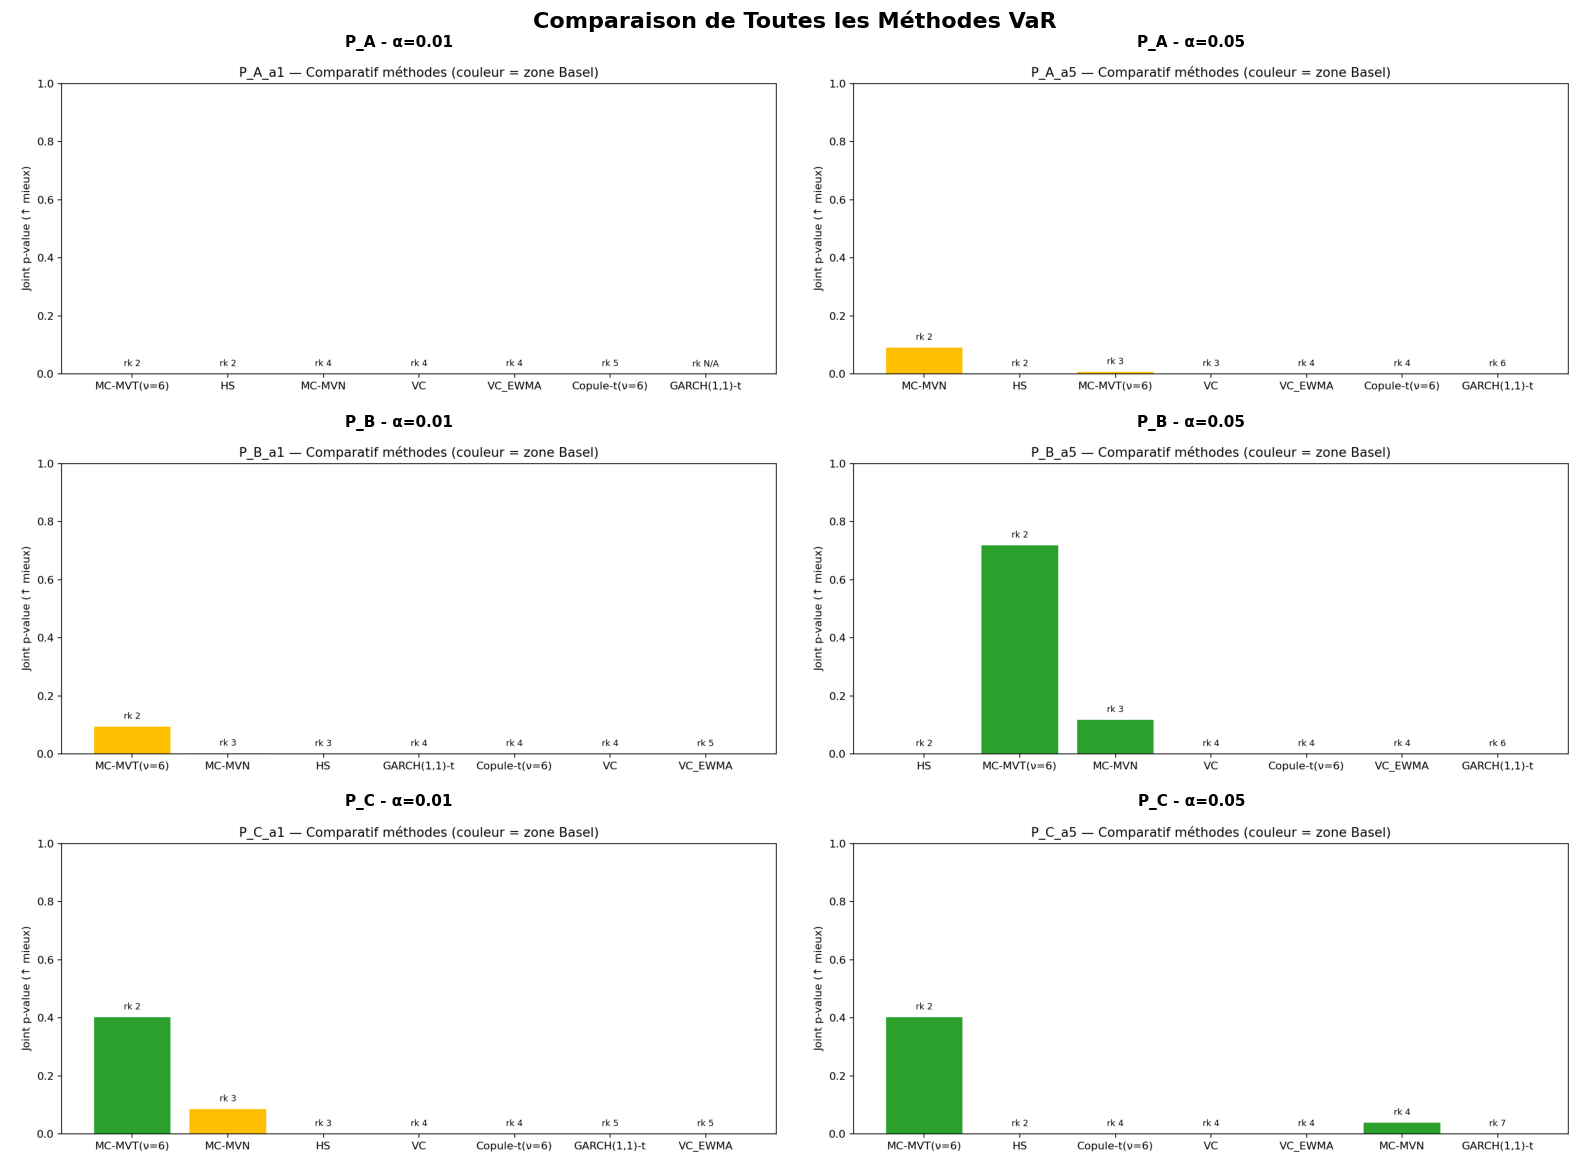


MODÈLES GAGNANTS PAR PORTEFEUILLE ET NIVEAU α
portfolio  alpha winner_model  rank_avg   zone  Kupiec_p  Christoff_p  Joint_p  ES_realised  breaches    T  hit_rate
      P_A 0.0100  MC-MVT(ν=6)    2.7500    red    0.0000       1.0000   0.0000       0.0512        64 2764    0.0232
      P_A 0.0500       MC-MVN    2.7500 yellow    0.0285       1.0000   0.0909       0.0387       164 2764    0.0593
      P_B 0.0100  MC-MVT(ν=6)    2.5000 yellow    0.0297       1.0000   0.0942       0.1275        36 2454    0.0147
      P_B 0.0500           HS    2.0000  green    0.8018       0.0000   0.0000       0.0848       120 2454    0.0489
      P_C 0.0100  MC-MVT(ν=6)    2.5000  green    0.1766       1.0000   0.4014       0.0675        35 2764    0.0127
      P_C 0.0500  MC-MVT(ν=6)    2.2500  green    0.1768       1.0000   0.4016       0.0446       123 2764    0.0445


In [19]:
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Paramètres
RESULTS_DIR = Path("results")
PORTS = ["P_A", "P_B", "P_C"]
ALPHAS = [1, 5]  # Correspond à a1 et a5 dans les noms de fichiers

# Créer une matrice de graphiques de comparaison
fig, axes = plt.subplots(len(PORTS), len(ALPHAS), figsize=(16, 12))
fig.suptitle('Comparaison de Toutes les Méthodes VaR',
             fontsize=16, fontweight='bold')

for i, port in enumerate(PORTS):
    for j, alpha in enumerate(ALPHAS):
        ax = axes[i, j]

        # Charger l'image générée
        img_file = RESULTS_DIR / f"compare_{port}_a{alpha}.png"

        if img_file.exists():
            img = imread(img_file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'{port} - α={alpha/100}', fontweight='bold', fontsize=11)
        else:
            ax.text(0.5, 0.5, f'Fichier non trouvé:\n{img_file.name}',
                    ha='center', va='center', fontsize=10)
            ax.axis('off')

plt.tight_layout()
plt.show()

# Afficher le tableau des gagnants
print("\n" + "="*90)
print("MODÈLES GAGNANTS PAR PORTEFEUILLE ET NIVEAU α")
print("="*90)

winners_file = RESULTS_DIR / "winners_by_portfolio_alpha.csv"
if winners_file.exists():
    import pandas as pd
    winners = pd.read_csv(winners_file)
    print(winners.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
else:
    print("Fichier winners_by_portfolio_alpha.csv non trouvé!")